<center><img src=https://reverehealth.com/_next/image/?url=https%3A%2F%2Frevere-health.hqdemo.app%2Fwp-content%2Fuploads%2FiStock_41704022_LARGE.jpg&w=2048&q=75></center>



<center><font size=6>Unsupervised Learning: Sleeping Disorder Cluster Analysis</font></center>

## Problem Statement

Sleep Apnea and insomnia are both major sleeping disorders. While both diseases can have different causes, a 2019 study [1] also suggests that each condition may increase the chance of the other, showing a relationship between two symptoms.

This study applies unsupervised machine learning techniques—particularly KMeans and Hierarchical Clustering—to a comprehensive dataset of patients exhibiting symptoms of sleep apnea or insomnia. By analyzing features such as age, activity level, blood pressure, sleep duration, and stress, this study explores how distinct patterns can inform targeted treatments and improve sleep-related health outcomes.

References:

1. Sweetman, A., Lack, L., & Bastien, C. (2019). Co-Morbid Insomnia and Sleep Apnea (COMISA): Prevalence, Consequences, Methodological Considerations, and Recent Randomized Controlled Trials. Brain Sciences, 9(12), 371. https://doi.org/10.3390/brainsci9120371

## Importing Necessary Libraries

In [1]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display formatting
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Preprocessing and distance metrics
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist, pdist

# Clustering models and evaluation
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Visualization tools for cluster evaluation
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Hierarchical clustering utilities
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## Importing Dataset

In [ ]:
# Reading the dataset
data = pd.read_csv('/content/Sleep_health_and_lifestyle_dataset.csv')

In [ ]:
# Copying data to another variable to avoid any changes to original data
df = data.copy()

## Data Overview

In [ ]:
# Checking the shape of the dataset
print(f'There are {df.shape[0]} number of rows and {df.shape[1]} number of columns.')

There are 374 number of rows and 13 number of columns.


In [ ]:
# Checking the random 10 rows of the dataset
df.sample(10, random_state = 1)

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
67,68,Male,33,Doctor,6.000,6,30,8,Normal,125/80,72,5000,Insomnia
318,319,Female,53,Engineer,8.400,9,30,3,Normal,125/80,65,5000,NaN
275,276,Female,49,Nurse,6.200,6,90,8,Overweight,140/95,75,10000,Sleep Apnea
260,261,Female,45,Teacher,6.600,7,45,4,Overweight,135/90,65,6000,Insomnia
90,91,Male,35,Engineer,7.300,8,60,4,Normal,125/80,65,5000,NaN
372,373,Female,59,Nurse,8.100,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
167,168,Male,41,Lawyer,7.100,7,55,6,Overweight,125/82,72,6000,NaN
322,323,Female,53,Engineer,8.400,9,30,3,Normal,125/80,65,5000,NaN
65,66,Male,32,Doctor,6.200,6,30,8,Normal,125/80,72,5000,NaN
150,151,Female,39,Accountant,8.000,9,80,3,Normal Weight,115/78,67,7500,NaN


In [ ]:
# Splitting the "Blood Pressure" column
df[["Systolic", "Diastolic"]] = df["Blood Pressure"].str.split("/", expand = True)

# Converting the new columns to integers
df["Systolic"] = df["Systolic"].astype(int)
df["Diastolic"] = df["Diastolic"].astype(int)

# Dropping the blood pressure column
df.drop('Blood Pressure', axis = 1, inplace = True)

* We split the Systolic and Diastolic from the Blood Pressure column for better analysis for each feature.

In [ ]:
# Checking the data type of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Heart Rate               374 non-null    int64  
 10  Daily Steps              374 non-null    int64  
 11  Sleep Disorder           155 non-null    object 
 12  Systolic                 374 non-null    int64  
 13  Diastolic                374 non-null    int64  
dtypes: float64(1), int64(9), o

* The dataset is consisted of both numeric and categorical features.
* Only Sleep Disorder column seems to have null values.

In [ ]:
# Checking the missing values
df.isnull().sum()

,0
Person ID,0
Gender,0
Age,0
Occupation,0
Sleep Duration,0
Quality of Sleep,0
Physical Activity Level,0
Stress Level,0
BMI Category,0
Heart Rate,0


* There are some null values in Sleep Disorder column, which is target variable if this was study for the Supervised Learning.

* Since we will be focusing on the patients with Sleeping Disorder, people without the evidence of the disease will not be studied.

In [ ]:
df.dropna(inplace = True)
df.isnull().any()

,0
Person ID,False
Gender,False
Age,False
Occupation,False
Sleep Duration,False
Quality of Sleep,False
Physical Activity Level,False
Stress Level,False
BMI Category,False
Heart Rate,False


* People with unknown status of the disease has been dropped.

## Data Description

### Numeric Columns

In [ ]:
df.describe()

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic
count,155.000,155.000,155.000,155.000,155.000,155.000,155.000,155.000,155.000,155.000
mean,244.761,46.632,6.812,6.871,60.897,5.768,71.787,6765.806,134.923,89.806
std,91.283,7.839,0.774,1.337,20.634,1.947,5.187,1893.922,5.397,4.869
min,4.000,28.000,5.800,4.000,30.000,3.000,65.000,3000.000,115.000,75.000
25%,199.500,43.000,6.300,6.000,45.000,4.000,68.000,6000.000,130.000,85.000
50%,255.000,45.000,6.500,7.000,45.000,7.000,72.000,6000.000,135.000,90.000
75%,304.500,51.000,7.400,8.000,75.000,7.000,75.000,7000.000,140.000,95.000
max,374.000,59.000,8.300,9.000,90.000,8.000,86.000,10000.000,142.000,95.000


### Observations:

* Age: Mean of 46.6 years (ranging from 28 to 59)

* Sleep Duration: Most patients sleep around 6.8 hours/night (range: 5.8 to 8.3)

* Daily Steps: Median of 6,000 steps, with a range from 3,000 to 10,000

* Physical Activity Level: Moderate overall, with a mean of ~61 on a 0–100 scale

* Quality of Sleep: Centered around 6.9 (scale 1–10), indicating moderate sleep satisfaction

* Stress Level: Average of 5.8 (range: 3–8), suggesting mid-to-high stress

* Heart Rate: Mean of ~72 bpm, within normal adult range

* Blood Pressure: Average systolic/diastolic is 135/90 mmHg

### Categorical Columns

In [ ]:
cat_cols = df.select_dtypes(include = 'object').columns.tolist()

for col in df[cat_cols].columns:
  print(df[col].value_counts(1))
  print('-' * 20)

Gender
Female   0.665
Male     0.335
Name: proportion, dtype: float64
--------------------
Occupation
Nurse                  0.413
Teacher                0.200
Salesperson            0.194
Doctor                 0.045
Accountant             0.045
Engineer               0.039
Lawyer                 0.032
Sales Representative   0.013
Scientist              0.013
Software Engineer      0.006
Name: proportion, dtype: float64
--------------------
BMI Category
Overweight      0.832
Normal          0.077
Obese           0.065
Normal Weight   0.026
Name: proportion, dtype: float64
--------------------
Sleep Disorder
Sleep Apnea   0.503
Insomnia      0.497
Name: proportion, dtype: float64
--------------------


### Observations:

* Gender distribution: 66.5% female / 33.5% male

* Most common occupations: Nurse (41%), Teacher (20%), and Salesperson (19%)

* BMI classification: 83% overweight / 7.7% normal weight / 6.5% obese

* Sleep disorder: 50.3% sleep apnea / 49.7% insomnia

## EDA (Exploratory Data Analysis)

### Univariate Analysis

### a) Numeric Features

In [ ]:
# Function to plot histogram and boxplot for numeric columns
def hist_boxplot(var, figsize = (10, 8)):
    """
    Visualizes a histogram and boxplot for a given numeric variable.

    Parameters:
    - var: Column name of the numeric variable.
    - figsize: Size of the combined plot set to default.

    Output:
    - Combined boxplot and histogram.
    """

    # Create subplot with 2 combined plots: boxplot & histogram
    fig, (ax_box, ax_hist) = plt.subplots(
        nrows = 2, sharex = True, figsize = figsize,
        gridspec_kw = {'height_ratios': (0.25, 0.75)}
    )

    # Visualize boxplot
    sns.boxplot(data = df, x = var, showmeans = True, ax = ax_box)

    # Visualize histogram
    sns.histplot(data = df, x = var, kde = True, ax = ax_hist)
    ax_hist.axvline(df[var].median(), color = 'black', linestyle = '--', label = 'Median')
    ax_hist.axvline(df[var].mean(), color = 'red', linestyle = '--', label = 'Mean')

    # Improve layout and display
    plt.tight_layout()
    ax_hist.legend()
    plt.show()

**Age**

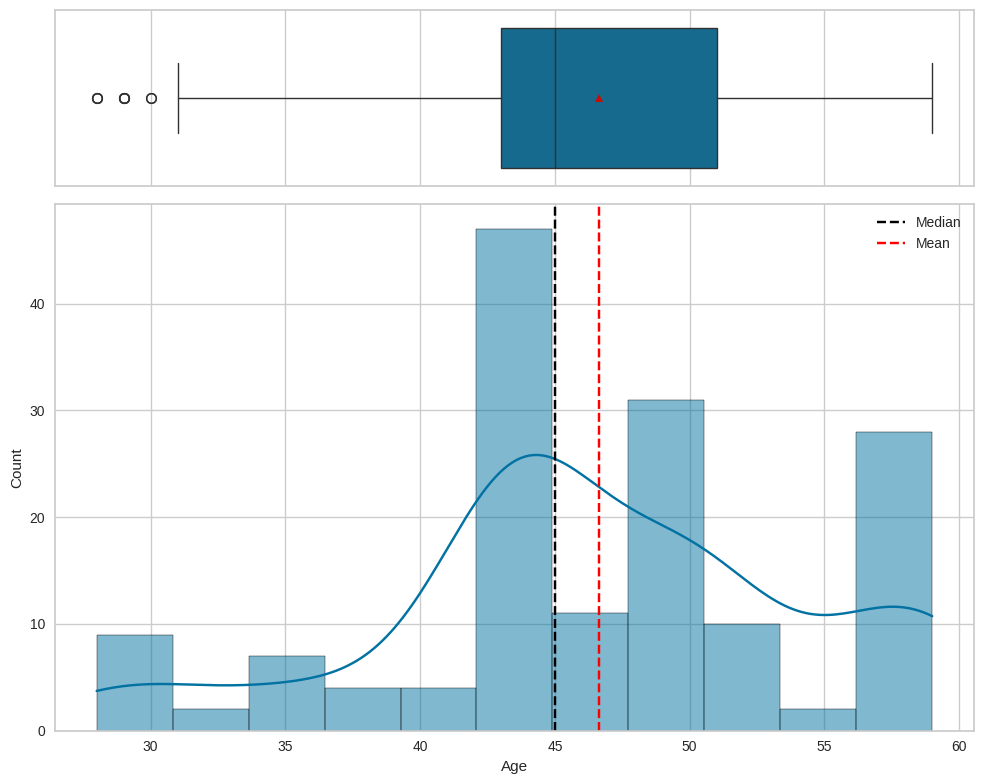

In [ ]:
hist_boxplot('Age')

* Both median and mean age are around 45.
* Most patients are between 43 and 51, suggesting middle age may be linked to sleep disorders.
* A few outliers in younger age are present, but the distribution is mostly centered.

**Sleep Duration**

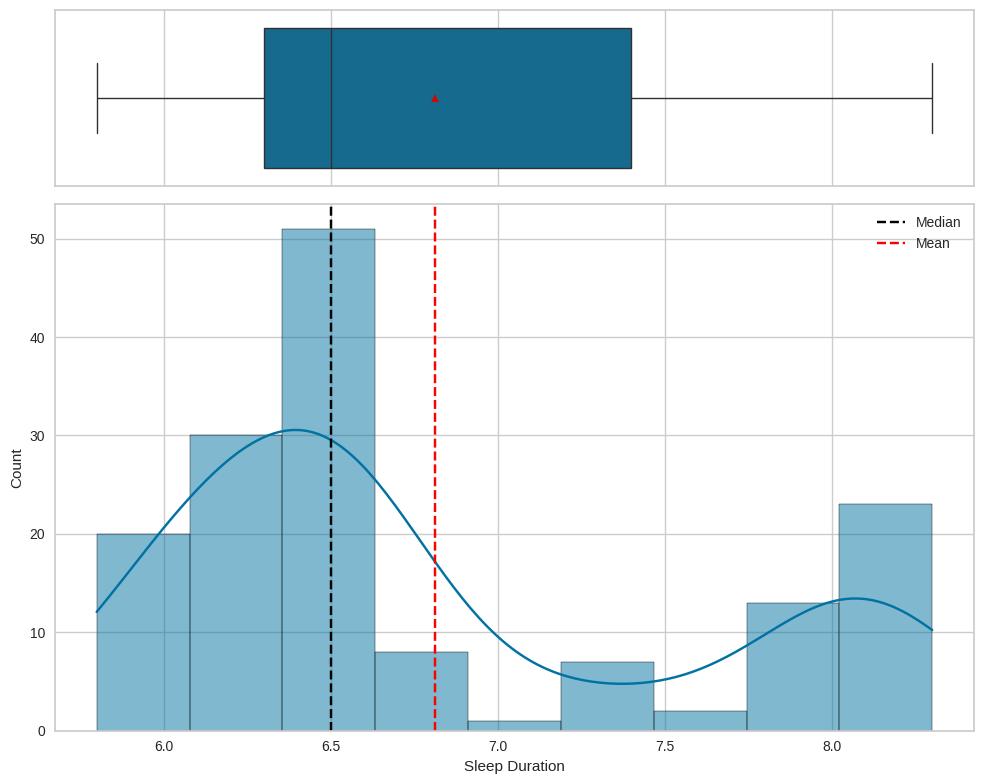

In [ ]:
hist_boxplot('Sleep Duration')

* Median sleep duration is around 6.5 hours.
* Most patients sleep between 6 and 7 hours.
* The distribution is slightly right-skewed, with some patients sleeping over 8 hours.

**Quality of Sleep**

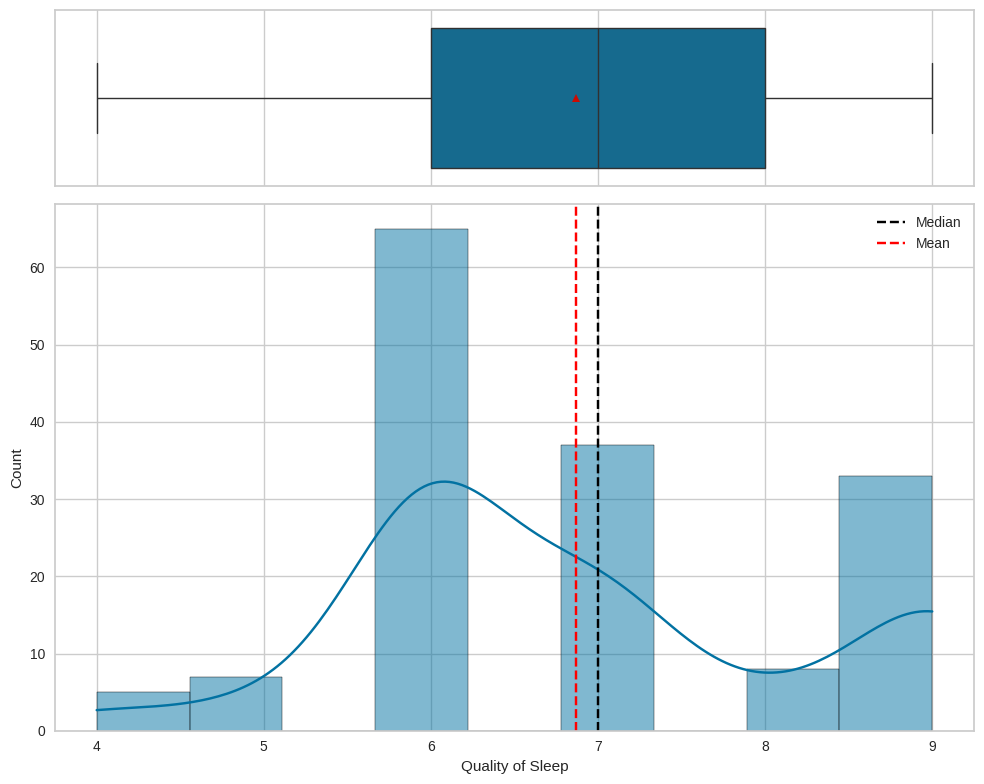

In [ ]:
hist_boxplot('Quality of Sleep')

* Median and mean sleep quality are both around 7.
* Most patients report sleep quality scores between 6 and 8.
* The distribution is slightly right-skewed.

**Physical Activity Level**

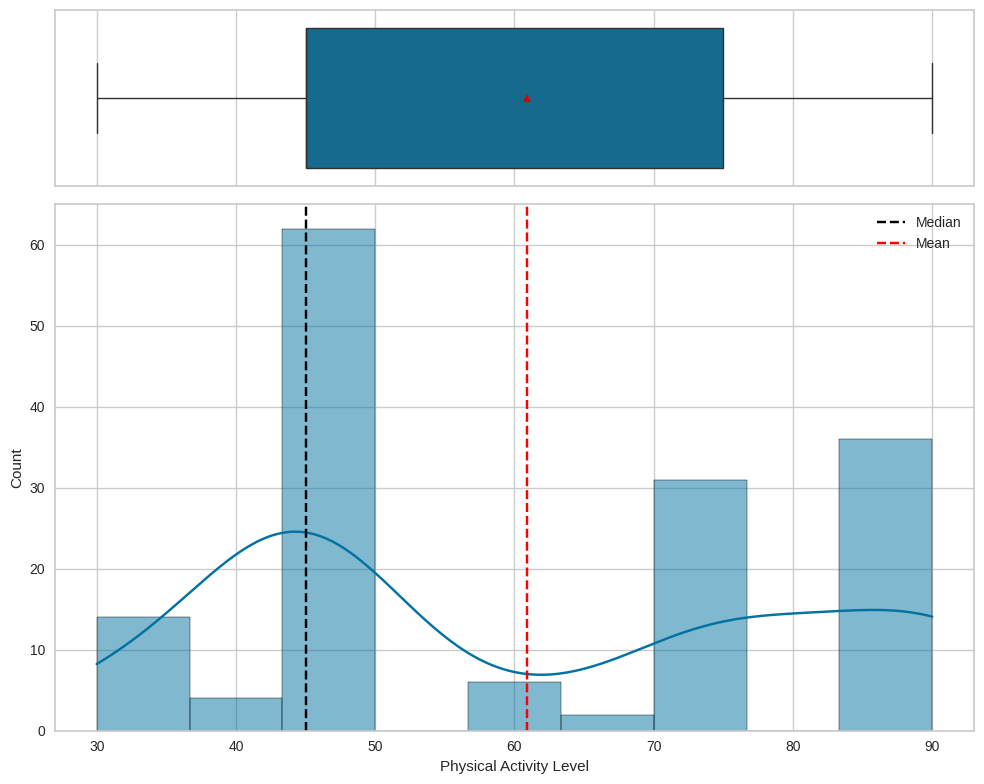

In [ ]:
hist_boxplot('Physical Activity Level')

* Median physical activity level is around 45.
* The distribution is bimodal, with a peak around 45.
* Activity levels vary widely.

**Stress Level**

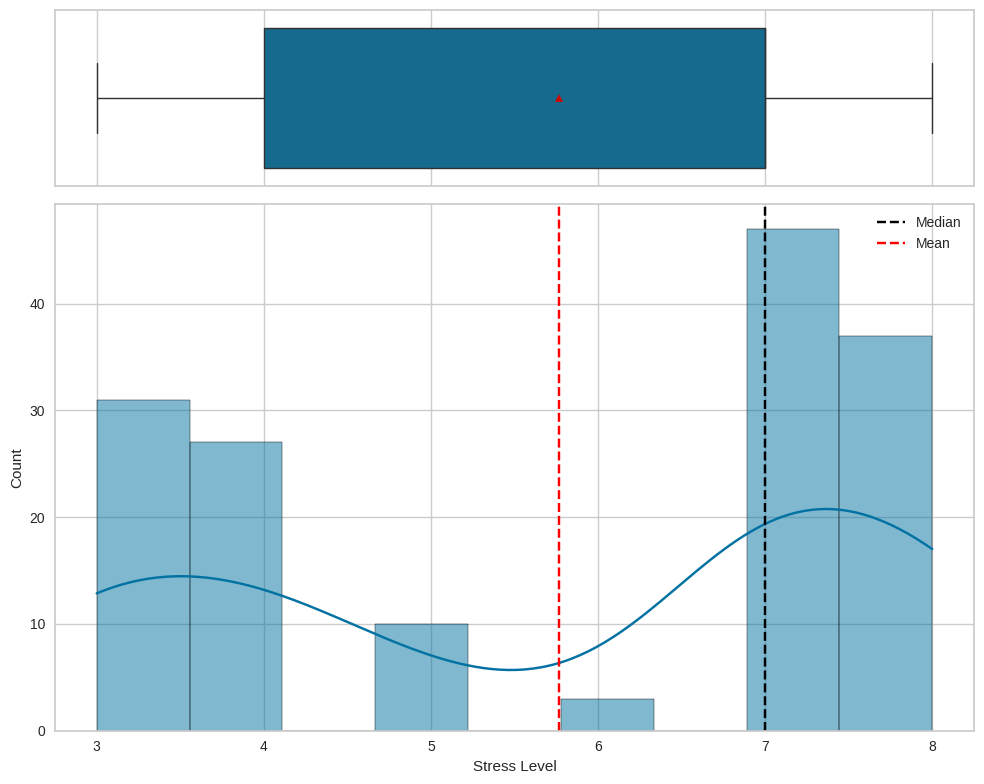

In [ ]:
hist_boxplot('Stress Level')

* Median stress level is around 7 with mean around 6.
* The distribution is bimodal, with patients at both low and high stress levels.

**Heart Rate**

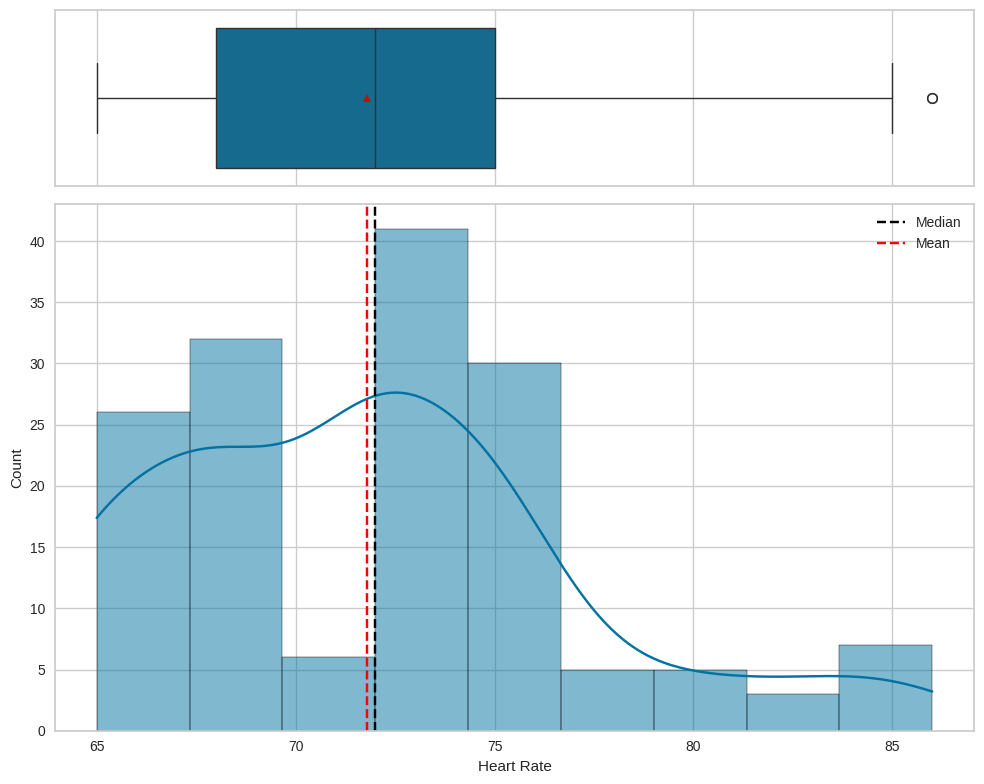

In [ ]:
hist_boxplot('Heart Rate')

* Mean and median heart rates are both near 72 bpm.
* Most values fall between 65 and 75 bpm.
* A few high outliers are present.

**Daily Steps**

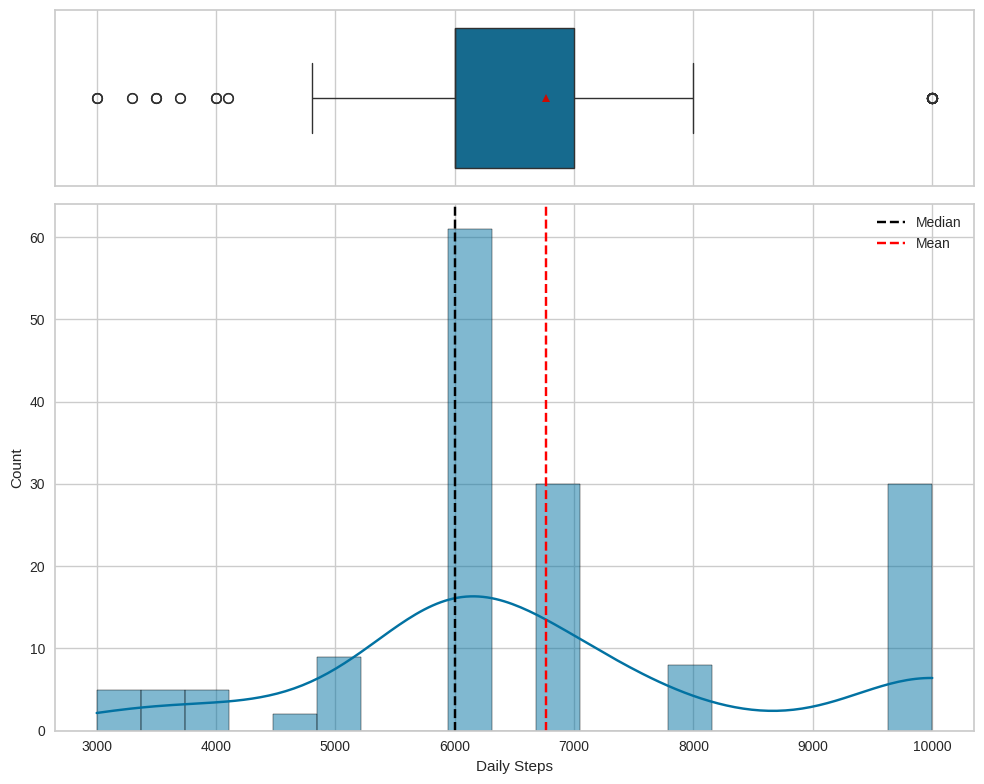

In [ ]:
hist_boxplot('Daily Steps')

* Median daily steps are just under 6,000, with the mean around 7,000.
* Most individuals walk between 5,000 and 7,000 steps per day.
* Both low and high step counts show several outliers.

**Systolic**

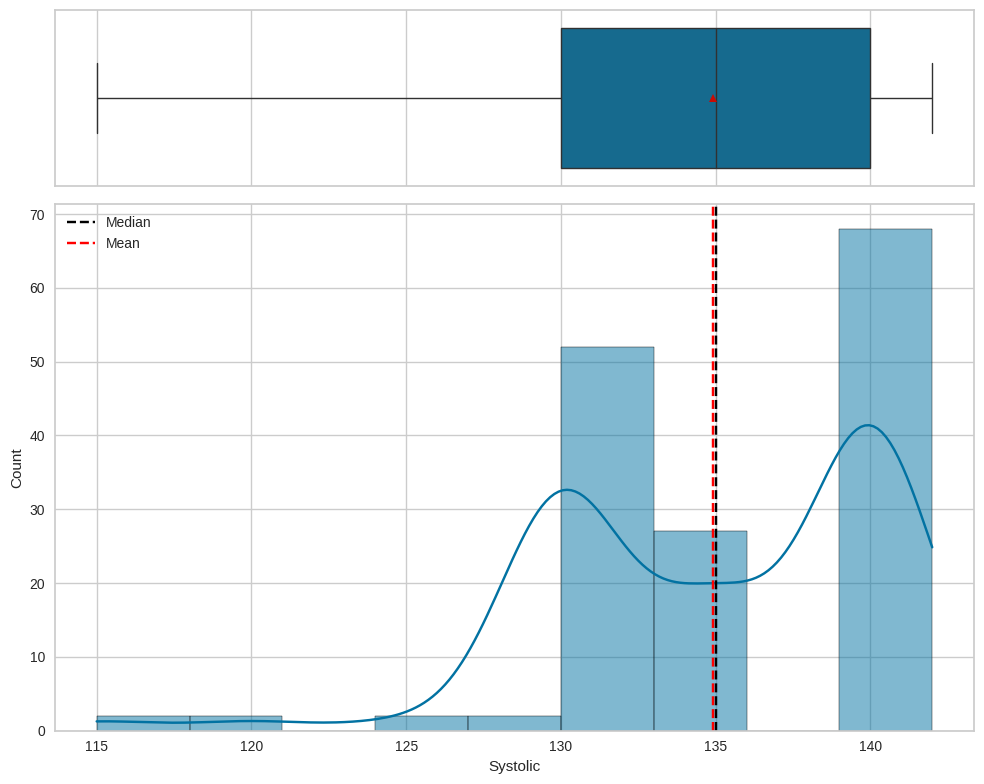

In [ ]:
hist_boxplot('Systolic')

* Median and mean systolic blood pressure are close, around 135 mmHg.
* Most values fall between 130 and 140 mmHg.
* Distribution shows slight right skew.

**Diastolic**

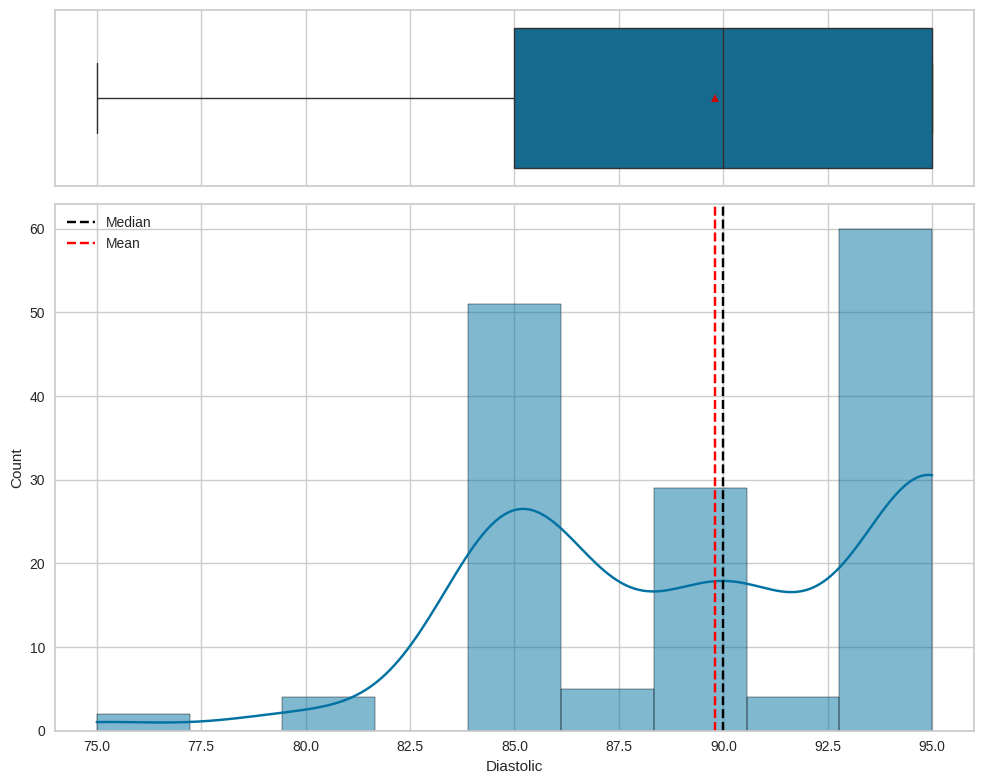

In [ ]:
hist_boxplot('Diastolic')

* Diastolic blood pressure centers around 90 mmHg with very close mean and median.
* Most values lie between 85 and 95 mmHg.

### b) Categorical Columns

In [ ]:
# Function to display a countplot with percentage labels for a categorical variable
def labeled_barplot(var):
    """
    Visualizes a labeled barplot with percentage for a given categorical variable.

    Parameters:
    - var: Column name of the categorical variable for visualization.

    Output:
    - A barplot with counts and percentage labels.
    """

    # Get the number of values in the variable and set the figure size
    count = df[var].nunique()
    plt.figure(figsize=(count + 3, 6))

    # Visualize the countplot
    ax = sns.countplot(data=df, x = var, order = df[var].value_counts().index[:],
                       palette = 'viridis', hue = var)

    # Total number of values in the feature to calculate percentages
    total = len(df[var])

    # Add percentage labels on top for each bar
    for p in ax.patches:
        # Calculate percentage of each category
        label = '{:.1f}%'.format(100 * p.get_height() / total)

        # Get the x and y coordinates for percentage label
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()

        # Annotate the plot with the percentage label
        ax.annotate(label, (x, y), ha = 'center', va = 'center',
                    xytext = (0, 6), size = 12, textcoords = 'offset points')

    # Show the final plot
    plt.show()

**Gender**

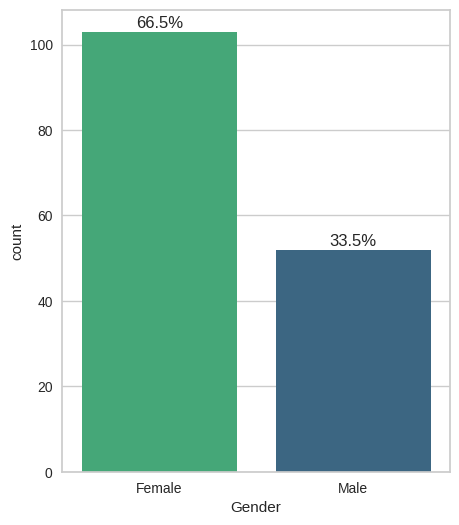

In [ ]:
labeled_barplot('Gender')

* Female patients are twice as much as male patients in this dataset.

**Occupation**

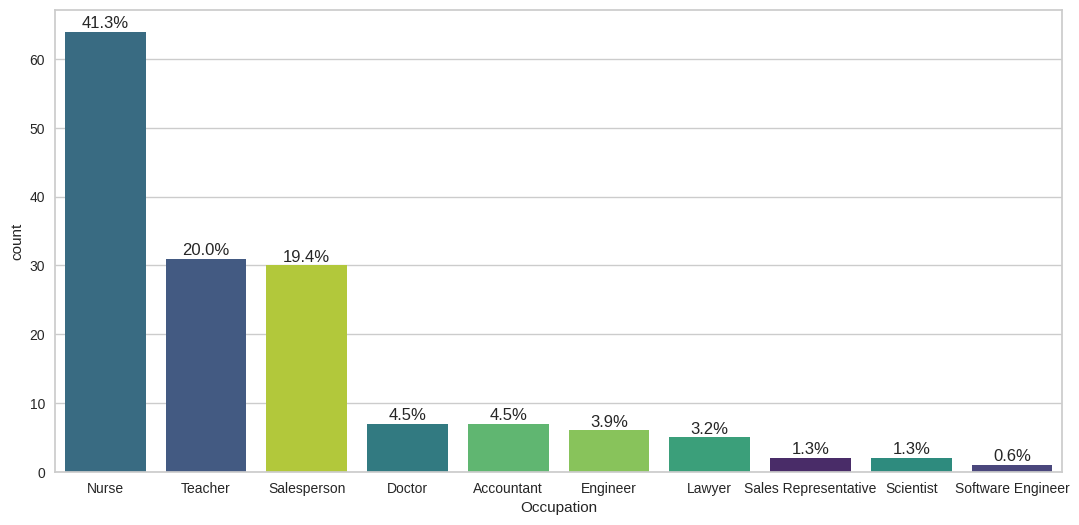

In [ ]:
labeled_barplot('Occupation')

* Nurse, teacher, salesperson show significantly higher proportion of occupation than others in this dataset.

**BMI Category**

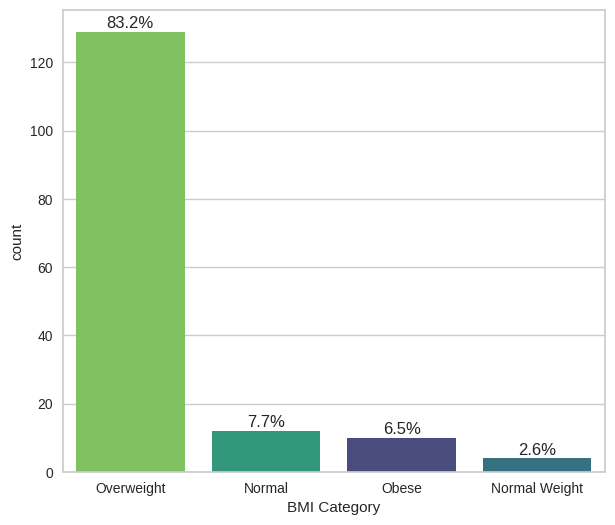

In [ ]:
labeled_barplot('BMI Category')

* Overweight consists vast majority of BMI Category.

**Sleep Disorder**

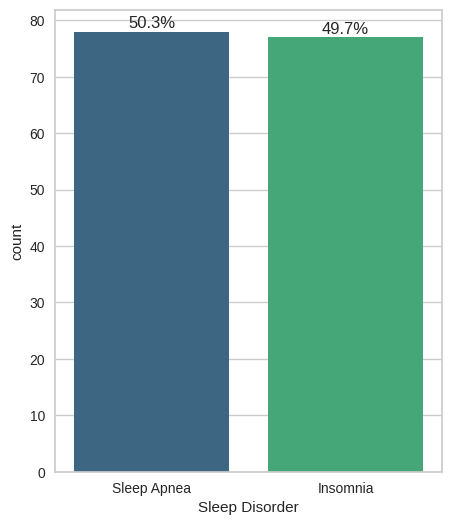

In [ ]:
labeled_barplot('Sleep Disorder')

* Sleep Apnea and Insomnia show very close distribution (50.3 vs 49.7)

## Bivariate Analysis

In [ ]:
# Converting the values in target variable into integer
df['Sleep Disorder'] = df['Sleep Disorder'].apply(lambda x: 1 if x == 'Insomnia' else 0)
df['Sleep Disorder'].value_counts(1)

,proportion
Sleep Disorder,
0,0.503
1,0.497


* Insomnia is converted to 1 and Sleep Apnea to 0.

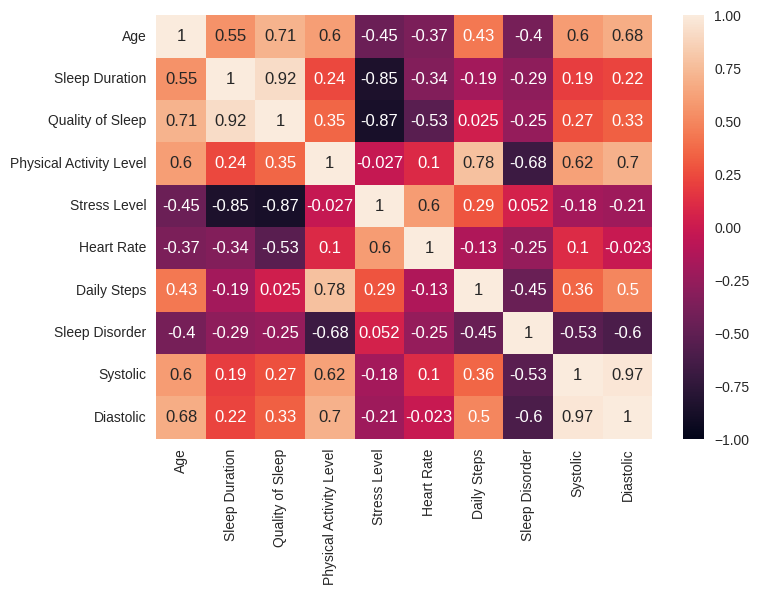

In [ ]:
# Heatmap

# Select numeric columns and remove Person ID
num_cols = df.select_dtypes(include = np.number).columns.tolist()
num_cols.remove('Person ID')

# Plot heatmap
sns.heatmap(df[num_cols].corr(), vmin = -1, vmax = 1, annot = True)
plt.show()

* Strongest correlations:

  * Quality of Sleep & Sleep Duration (0.92)
  * Systolic & Diastolic (0.97)
  * Stress Level & (–) Sleep Duration (–0.85), Quality of Sleep (–0.87)

* Age positively correlates with most health indicators, especially Quality of Sleep (0.71), Diastolic (0.68), and Systolic (0.60).

* Physical Activity Level is strongly tied to Daily Steps (0.78) and negatively to Sleep Disorder (–0.68).

* Heart Rate is moderately associated with Stress Level (0.60).

In [ ]:
# Function to plot Diabetes and numeric varaibles
def distribution_plot(data, predictor, target):

  """
  Visualizes the distribution of a numeric variable (predictor) across different classes of the target variable.

  Parameters:
  - predictor: Name of the numeric predictor variable.
  - target: Name of the binary target variable (Status).

  Output:
  - Histogram for group with Sleep Apnea
  - Histogram for group with Insomnia
  - Boxplot with outliers
  - Boxplot without outliers
  """

  fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 8))

  target_uniq = data[target].unique()

  # histogram of predictor that counts non-diabetic patients
  axs[0, 0].set_title(f'Histogram Distribution of {target} (Sleep Apnea)')
  sns.histplot(data = data[data[target] == target_uniq[0]], x = predictor, kde = True, ax = axs[0, 0], color = 'teal', stat = 'density')

  # histogram of predictor that counts diabetic patients
  axs[0, 1].set_title(f'Histogram Distribution of {target} (Insomnia)')
  sns.histplot(data = data[data[target] == target_uniq[1]], x = predictor, kde = True, ax = axs[0, 1], color = 'orange', stat = 'density')

  # boxplot of predictor and target with outliers
  axs[1, 0].set_title(f'Boxplot of {target} by {predictor}')
  sns.boxplot(data = data, x = target, y = predictor, ax = axs[1, 0], palette = 'pastel', hue = target, legend = False, showmeans = True)

  # boxplot of predictor and target without outliers
  axs[1, 1].set_title(f'Boxplot of {target} by {predictor} without outliers')
  sns.boxplot(data = data, x = target, y = predictor, ax = axs[1, 1], palette = 'pastel', showfliers = False, hue = target, legend = False, showmeans = True)

  plt.tight_layout()
  plt.show()

**Sleep Disorder & Age**

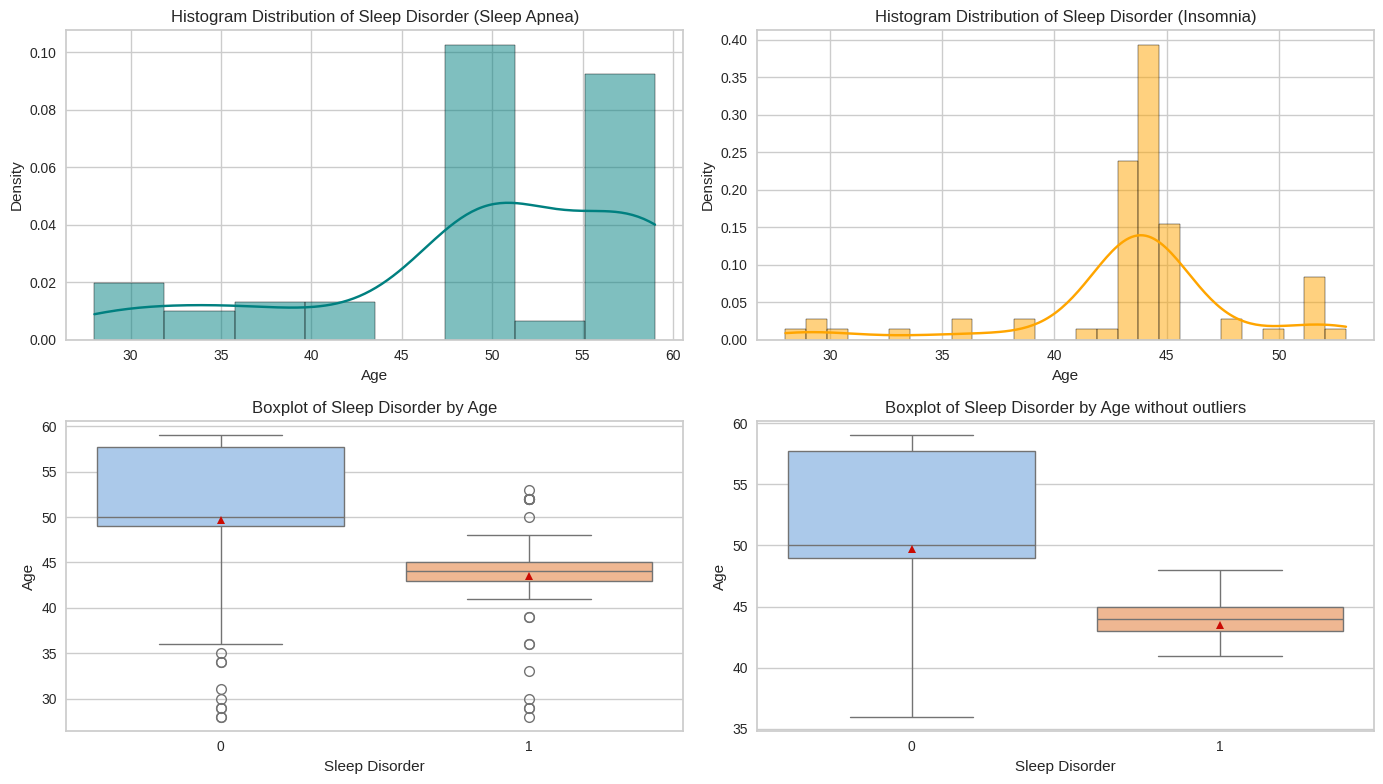

In [ ]:
distribution_plot(df, 'Age', 'Sleep Disorder')

* Sleep apnea occurs more in older individuals, with a wider age spread.
* Insomnia is more common among younger individuals with a narrower range.
* Median and mean age are higher for apnea than insomnia.

**Sleep Disorder & Sleep Duration**

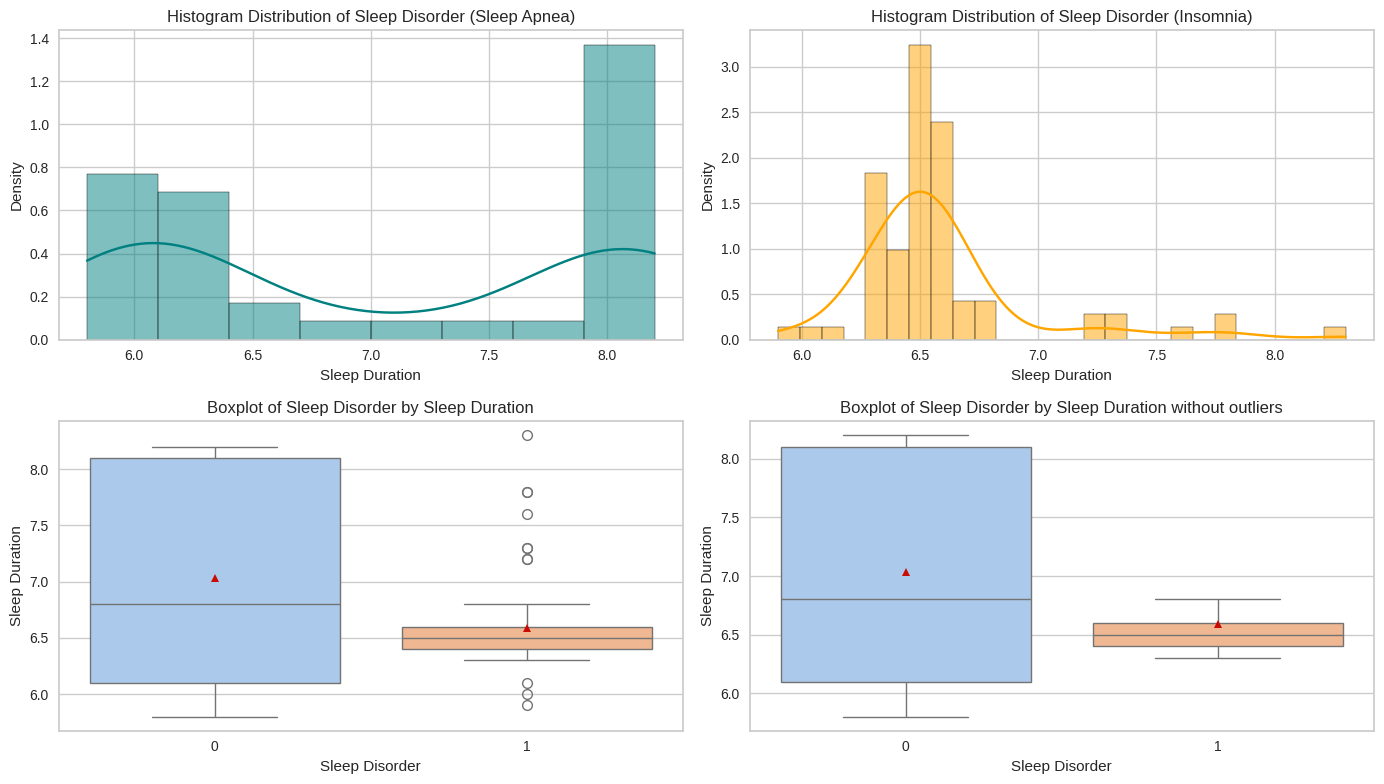

In [ ]:
distribution_plot(df, 'Sleep Duration', 'Sleep Disorder')

* Sleep apnea group shows a wider range of sleep duration.
* Insomnia group has consistently shorter sleep durations.
* Mean and median sleep duration are higher for apnea than insomnia.

**Sleep Disorder & Quality of Sleep**

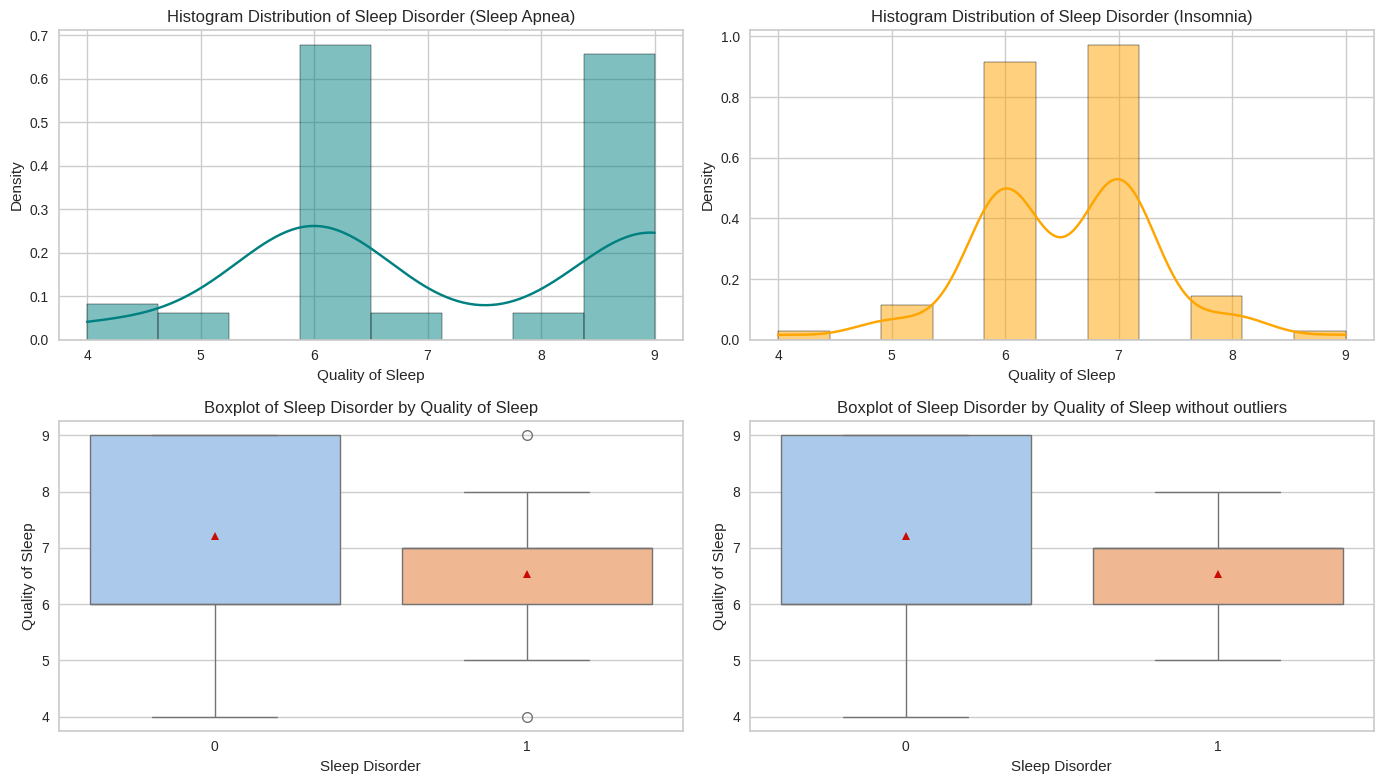

In [ ]:
distribution_plot(df, 'Quality of Sleep', 'Sleep Disorder')

* Sleep apnea group has higher quality of sleep, with more variation.
* Insomnia group reports consistently lower quality.
* Median and mean are both higher for apnea than insomnia.

**Sleep Disorder & Physical Activity Level**

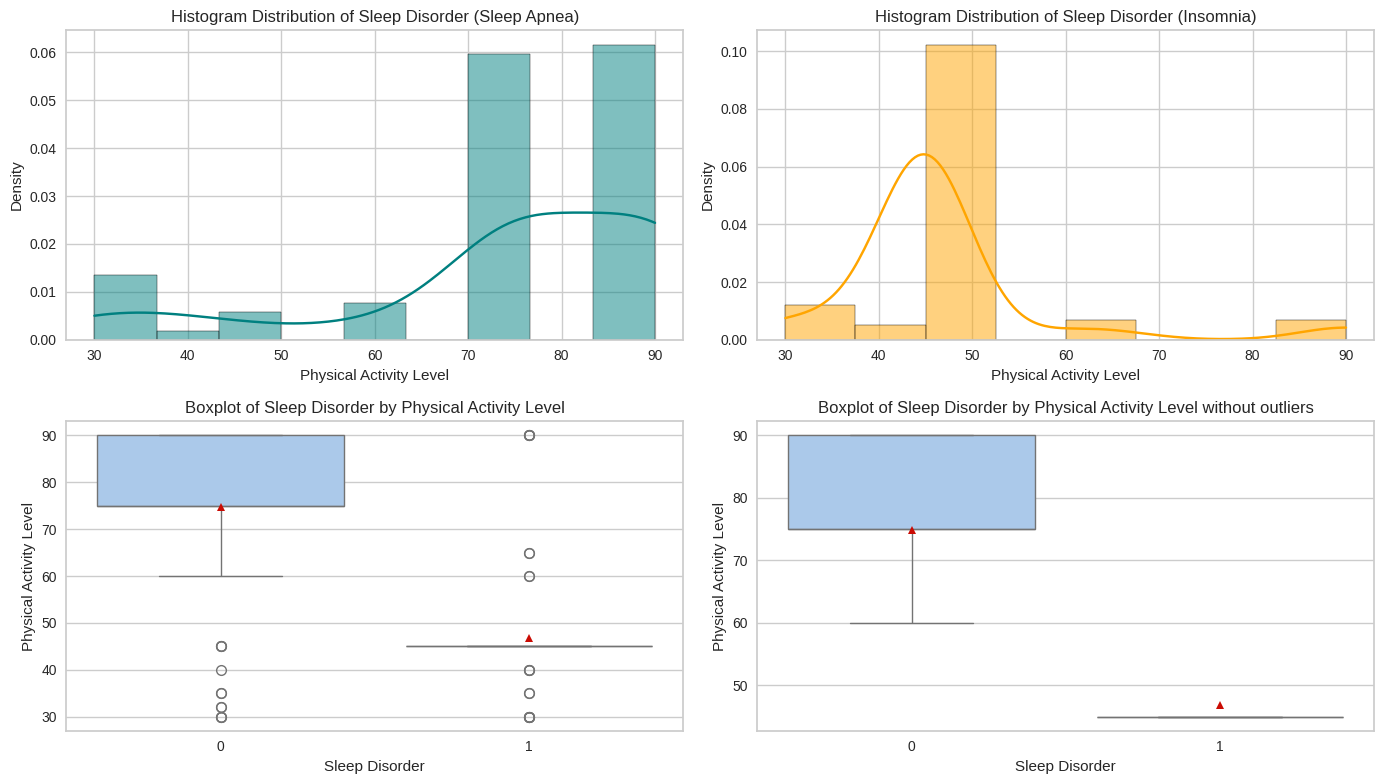

In [ ]:
distribution_plot(df, 'Physical Activity Level', 'Sleep Disorder')

* Sleep apnea group shows wider variation in physical activity.
* Insomnia group clusters tightly around low activity (~45).
* Apnea group is more active on average than insomnia.

**Sleep Disorder & Stress Level**

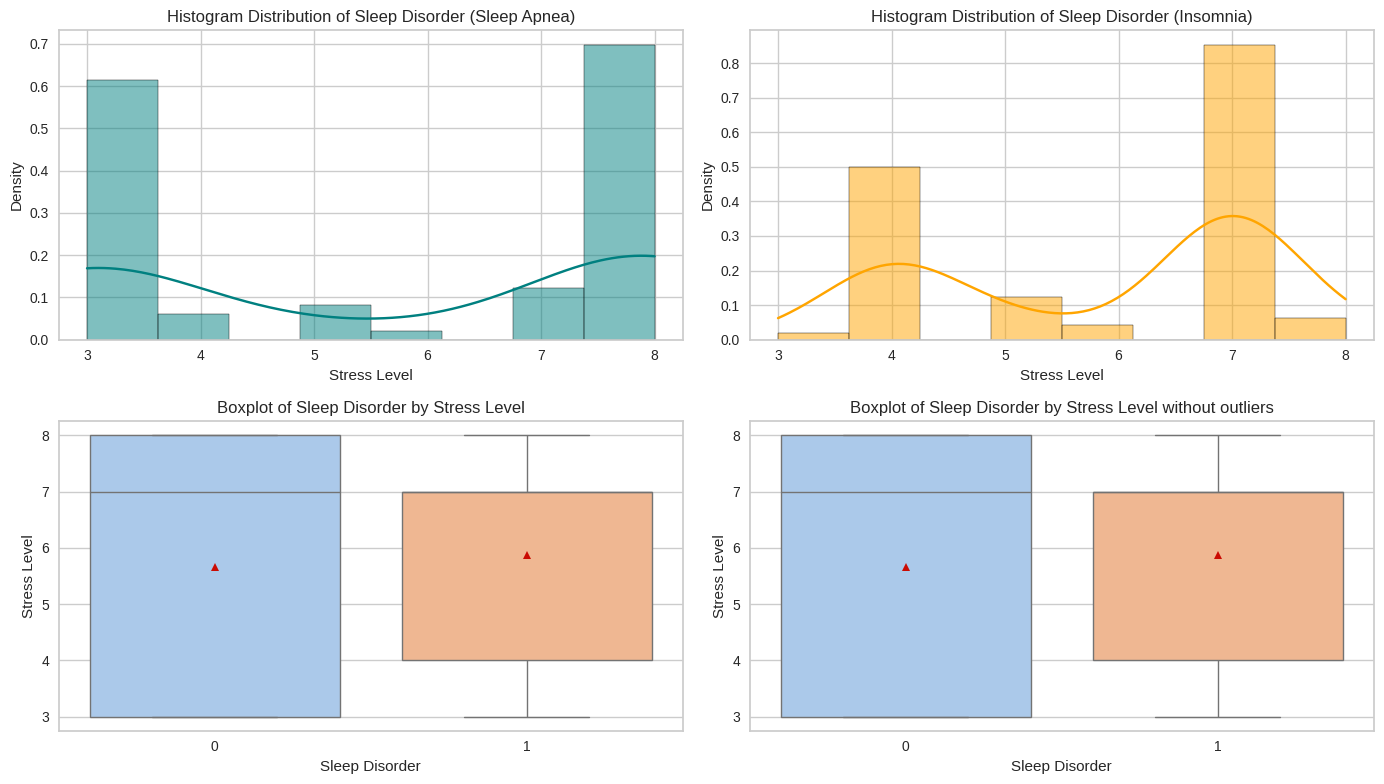

In [ ]:
distribution_plot(df, 'Stress Level', 'Sleep Disorder')

* Both groups have a bimodal stress pattern, with many samples at both low and high levels.
* Mean and median stress are slightly higher for insomnia than apnea.

**Sleep Disorder & Heart Rate**

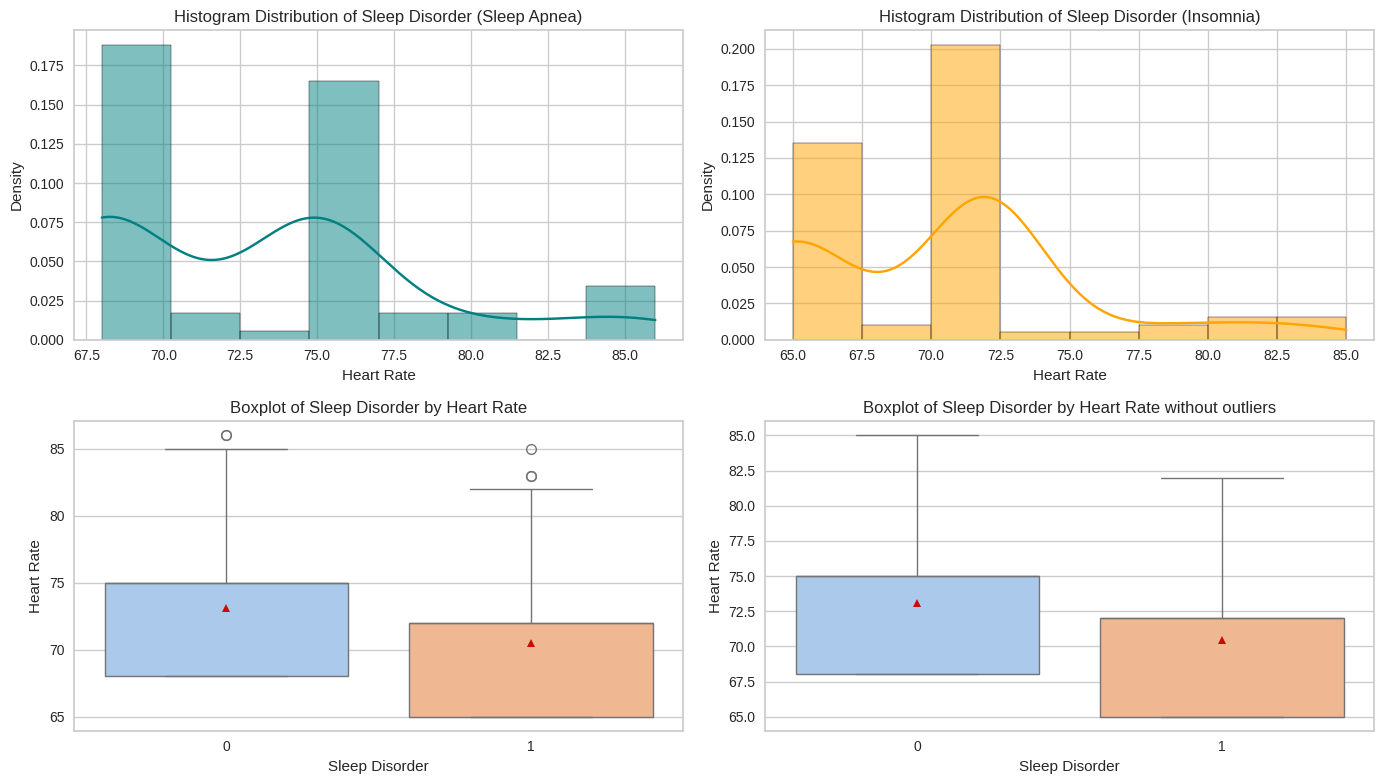

In [ ]:
distribution_plot(df, 'Heart Rate', 'Sleep Disorder')

* Sleep apnea group shows greater heart rate variability with a wider spread.
* Both mean and median heart rates are slightly higher for apnea than insomnia.

**Sleep Disorder & Daily Steps**

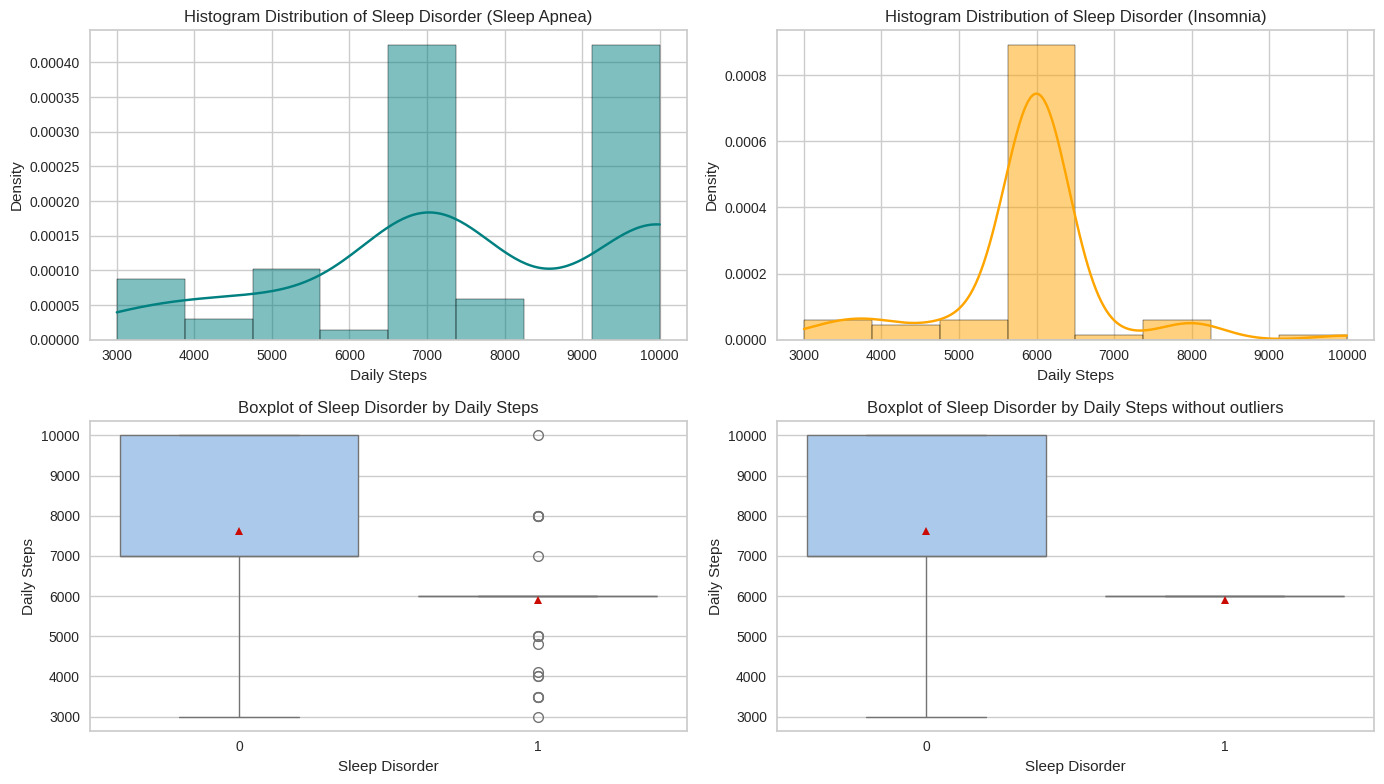

In [ ]:
distribution_plot(df, 'Daily Steps', 'Sleep Disorder')

* Sleep apnea group tends to walk more than insomnia group.
* Insomnia group is tightly clustered around fewer steps.

**Sleep Disorder & Systolic**

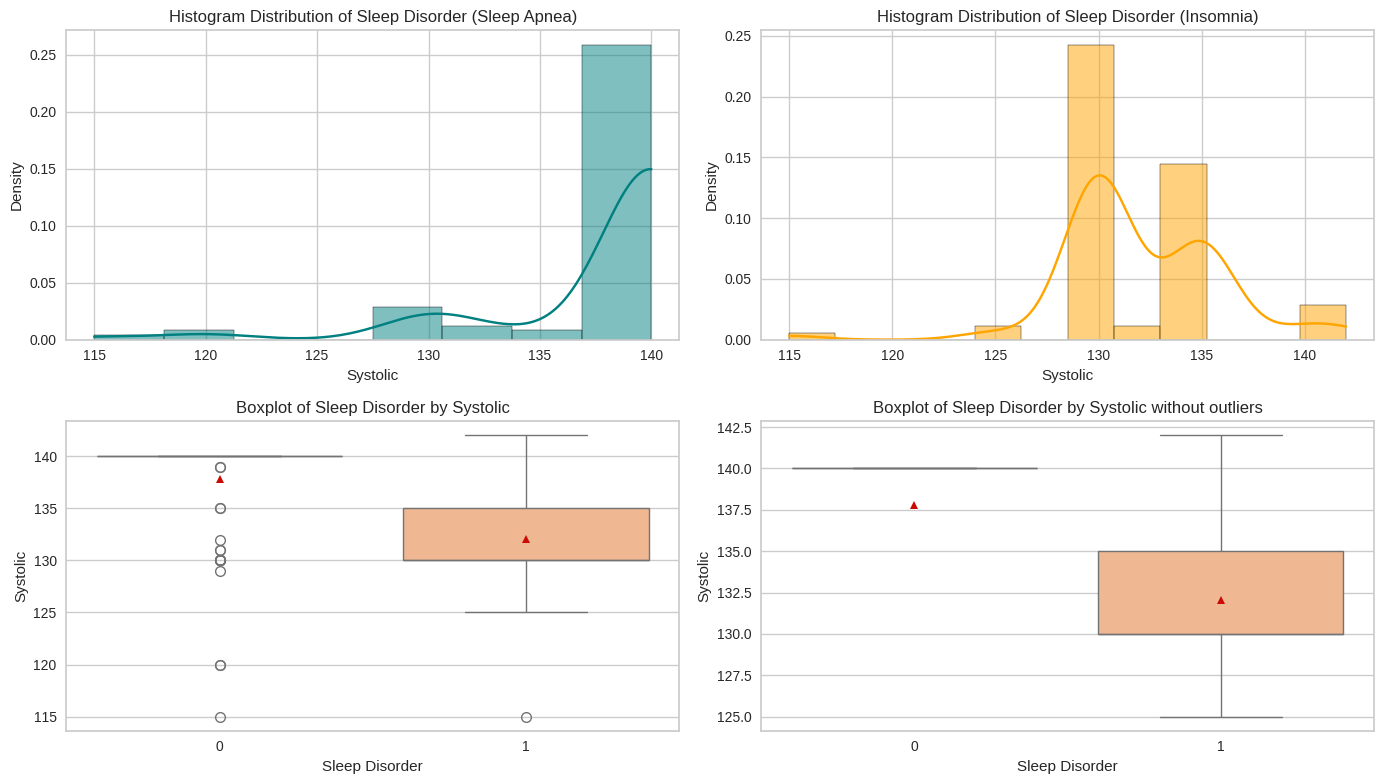

In [ ]:
distribution_plot(df, 'Systolic', 'Sleep Disorder')

* Sleep apnea group has slightly higher systolic pressure, with a wider spread.
* Insomnia group clusters more focused around 130–135.

**Sleep Disorder & Diastolic**

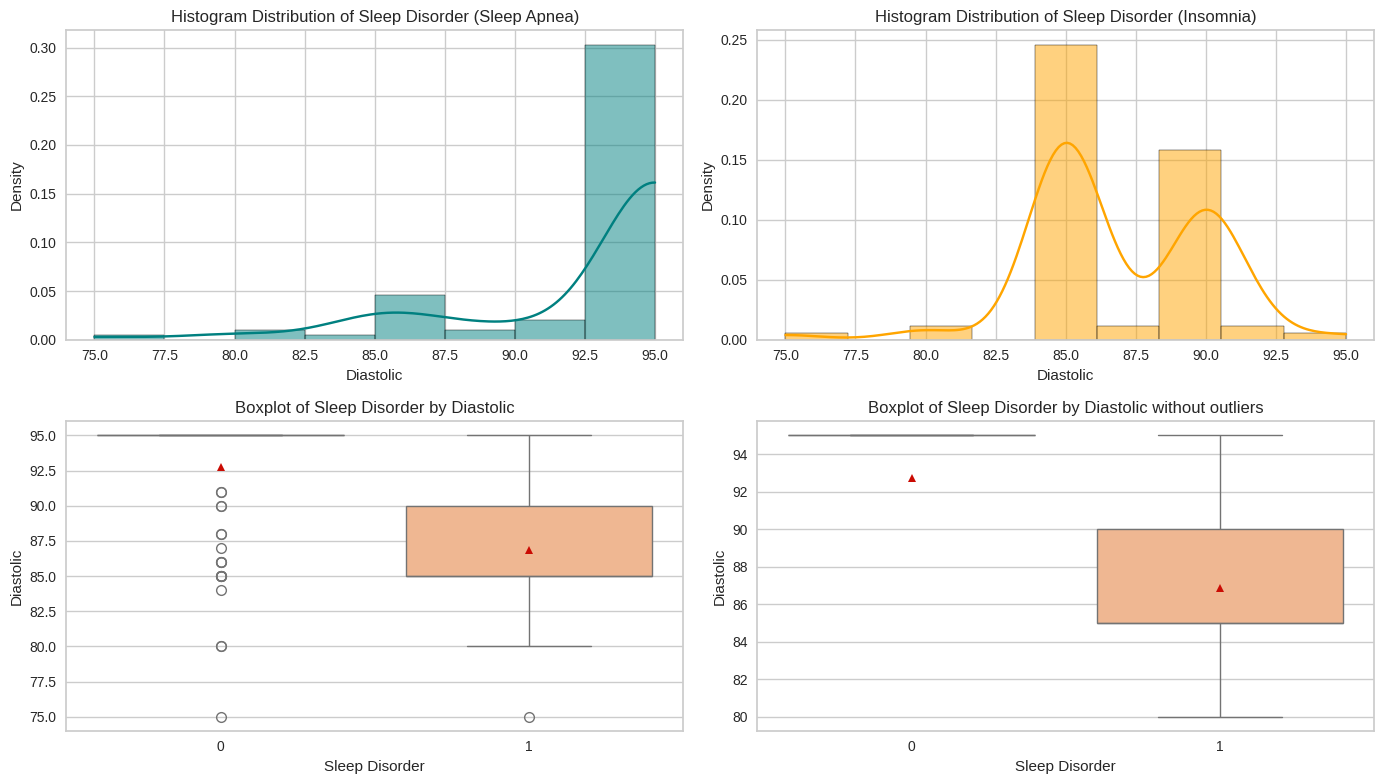

In [ ]:
distribution_plot(df, 'Diastolic', 'Sleep Disorder')

* Sleep apnea group has higher diastolic pressure, clustered near 95.
* Insomnia group shows more variation but lower central tendency.

In [ ]:
# Function to plot the correlation status and categorical variables
def stacked_barplot(predictor, target):
    """
    Plots a stacked bar chart showing the distribution of a categorical predictor
    variable across the target variable.

    Parameters:
    - predictor: Name of the categorical predictor variable.
    - target: Name of the binary target variable (Sleep Disorder).

    Output:
    - Frequency table of predictor vs. target
    - Normalized stacked bar plot
    """
    # Number of unique categories in the predictor
    count = df[predictor].nunique()

    # Identify the minority class to sort the plot accordingly
    sorter = df[target].value_counts().index[-1]

    # Print frequency table
    freq_table = pd.crosstab(df[predictor], df[target], margins = True).sort_values(by = sorter, ascending = False)
    print(freq_table, '\n')

    # Normalized table for plotting
    normalized_table = pd.crosstab(df[predictor], df[target], normalize = 'index').sort_values(by = sorter, ascending = False)

    # Set up figure size dynamically
    plt.figure(figsize = (count + 4, 5))

    # Generate the stacked barplot
    ax = normalized_table.plot(kind = 'bar', stacked = True)

    # Display djustments
    plt.title(f"Distribution of {target} by {predictor}")
    plt.xlabel(predictor)
    plt.ylabel("Proportion")
    plt.xticks(rotation = 0)
    plt.legend(title = target, loc = 'upper left', bbox_to_anchor = (1, 1))
    plt.subplots_adjust(right = 0.8)

    # Improve layout and display
    plt.tight_layout()
    plt.show()

Sleep Disorder   0   1  All
Gender                     
All             78  77  155
Male            11  41   52
Female          67  36  103 



<Figure size 600x500 with 0 Axes>

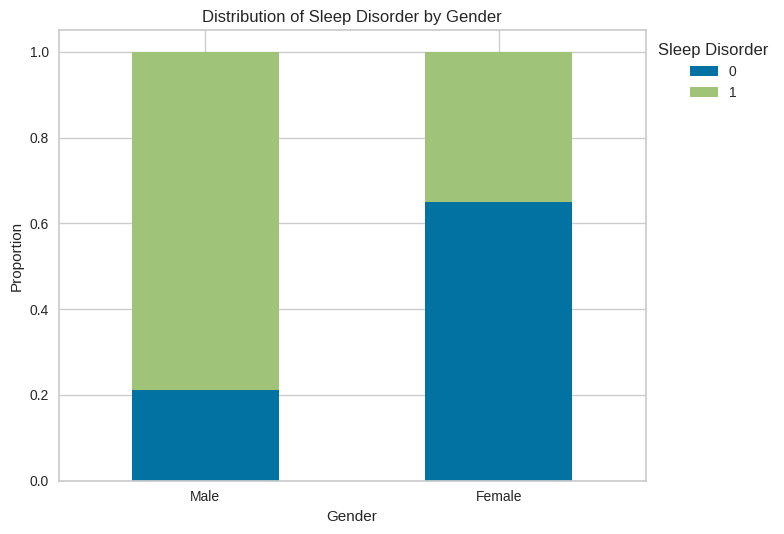

In [ ]:
stacked_barplot('Gender', 'Sleep Disorder')

* Sleep apnea is more common in females.
* Insomnia dominates among males, accounting for nearly 80%.

In [ ]:
# Function to plot the correlation status and Occupation
def stacked_barplot2(predictor, target):
    """
    Plots a stacked bar chart showing the distribution of a categorical predictor
    variable across the target variable.

    Parameters:
    - predictor: Name of the categorical predictor variable.
    - target: Name of the binary target variable (Sleep Disorder).

    Output:
    - Frequency table of predictor vs. target
    - Normalized stacked bar plot
    """
    # Number of unique categories in the predictor
    count = df[predictor].nunique()

    # Identify the minority class to sort the plot accordingly
    sorter = df[target].value_counts().index[-1]

    # Print frequency table
    freq_table = pd.crosstab(df[predictor], df[target], margins = True).sort_values(by = sorter, ascending = False)
    print(freq_table, '\n')

    # Normalized table for plotting
    normalized_table = pd.crosstab(df[predictor], df[target], normalize = 'index').sort_values(by = sorter, ascending = False)

    # Set up figure size dynamically
    plt.figure(figsize = (count + 4, 5))

    # Generate the stacked barplot
    ax = normalized_table.plot(kind = 'bar', stacked = True)

    # Display djustments
    plt.title(f"Distribution of {target} by {predictor}")
    plt.xlabel(predictor)
    plt.ylabel("Proportion")
    plt.xticks(rotation = 90)
    plt.legend(title = target, loc = 'upper left', bbox_to_anchor = (1, 1))
    plt.subplots_adjust(right = 0.8)

    # Improve layout and display
    plt.tight_layout()
    plt.show()

* Since Occupation has many values (some of them with long names), we set another function for Occupation for better visualization.

Sleep Disorder         0   1  All
Occupation                       
All                   78  77  155
Salesperson            1  29   30
Teacher                4  27   31
Accountant             0   7    7
Engineer               1   5    6
Doctor                 4   3    7
Nurse                 61   3   64
Lawyer                 3   2    5
Software Engineer      0   1    1
Sales Representative   2   0    2
Scientist              2   0    2 



<Figure size 1400x500 with 0 Axes>

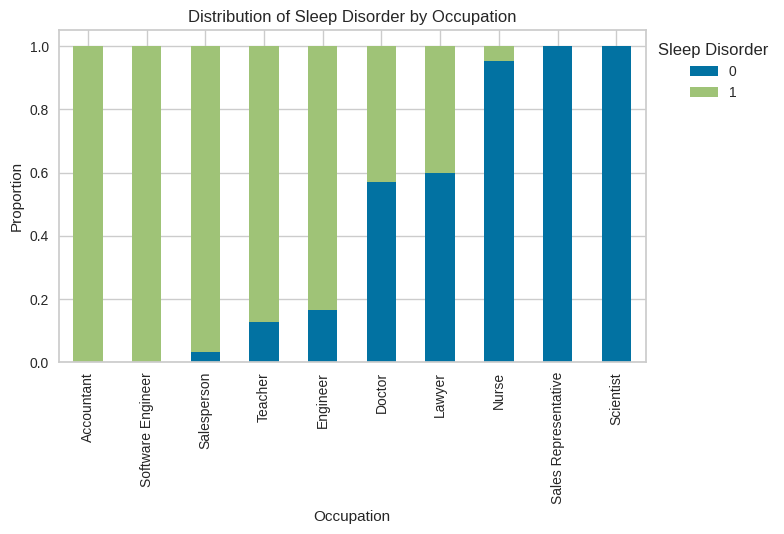

In [ ]:
stacked_barplot2('Occupation', 'Sleep Disorder')

* Insomnia dominates in accountant, software engineer, salesperson, teacher, and engineer.
* Doctor and lawyer shows moderate distribution of both sleeping disorder.
* Sleep Apnea dominates in nurse, sales representative and scientist.

Sleep Disorder   0   1  All
BMI Category               
All             78  77  155
Overweight      65  64  129
Normal           5   7   12
Obese            6   4   10
Normal Weight    2   2    4 



<Figure size 800x500 with 0 Axes>

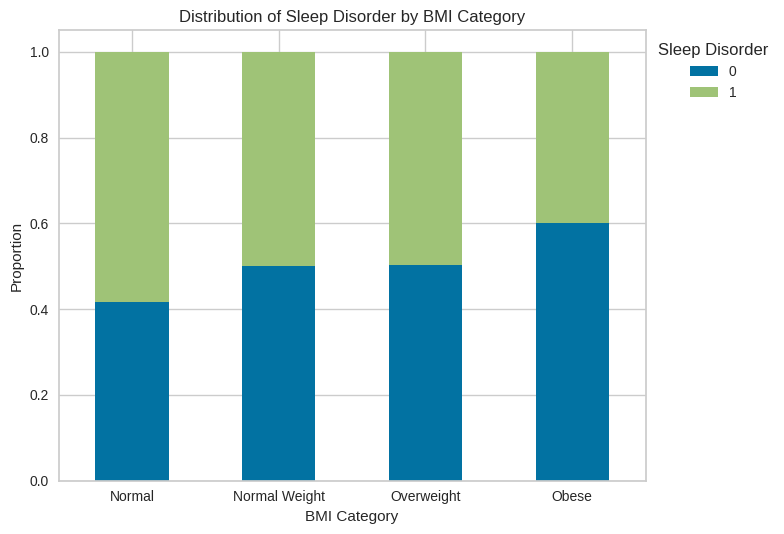

In [ ]:
stacked_barplot('BMI Category', 'Sleep Disorder')

* Insomnia is more common in normal BMI groups.
* Sleep apnea becomes more prevalent as BMI increases.

## Data Preprocessing

### Scaling

In [ ]:
# Select the numeric columns
num_cols = df.select_dtypes(np.number).columns.tolist()

# Scaling the data before clustering
scaler = StandardScaler()
subset = df[num_cols]
subset_scaled = scaler.fit_transform(subset)

# Creating a dataframe of the scaled data
subset_df = pd.DataFrame(subset_scaled, columns = subset.columns)

## Clustering

### KMeans Clustering

In [ ]:
# Copy the dataset for KMeans clustering
k_means_df = subset_df.copy()

Number of Clusters: 1 / Average Distortion: 3.176484104434195
Number of Clusters: 2 / Average Distortion: 2.3520643584060514
Number of Clusters: 3 / Average Distortion: 2.139550660756039
Number of Clusters: 4 / Average Distortion: 1.322179388602099
Number of Clusters: 5 / Average Distortion: 1.0380623462972145
Number of Clusters: 6 / Average Distortion: 0.9282998121909534
Number of Clusters: 7 / Average Distortion: 0.8314003812891068
Number of Clusters: 8 / Average Distortion: 0.7725643062910484
Number of Clusters: 9 / Average Distortion: 0.6655741331700576
Number of Clusters: 10 / Average Distortion: 0.6391552292967051
Number of Clusters: 11 / Average Distortion: 0.5984223931574992
Number of Clusters: 12 / Average Distortion: 0.5808769957512594
Number of Clusters: 13 / Average Distortion: 0.5511332517327607
Number of Clusters: 14 / Average Distortion: 0.5362041716168354


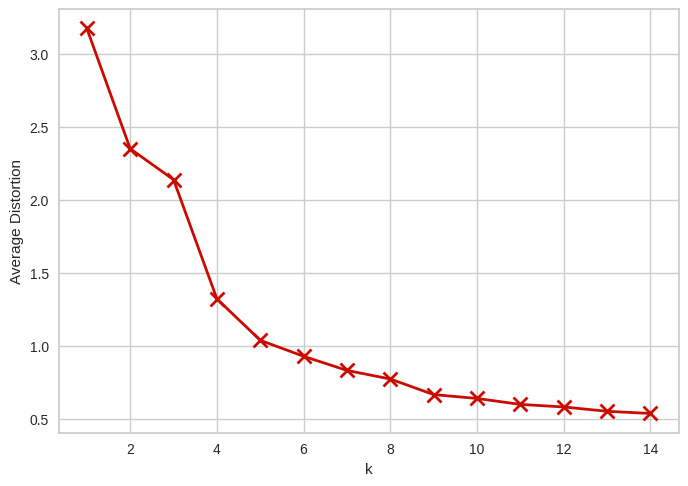

In [ ]:
# Define range of cluster numbers to test
clusters = range(1, 15)

# Define a list to store the average distortion for each k
meanDistortions = []

# Loop through each k to fit KMeans and compute average distortion
for k in clusters:
    model = KMeans(n_clusters = k, random_state = 1)
    model.fit(subset_df)

    # Compute distortion -> average distance from each point to its cluster center
    distortion = (
        sum(np.min(cdist(k_means_df, model.cluster_centers_, 'euclidean'), axis=1)) /
        k_means_df.shape[0]
    )

    # Store result
    meanDistortions.append(distortion)
    print(f'Number of Clusters: {k} / Average Distortion: {distortion}')

# Plot the elbow curve to identify optimal k
plt.plot(clusters, meanDistortions, 'rx-', markersize=10, markeredgewidth=2, linewidth=2)
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.show()

* There are steep drops in average distortion from k = 1 to k = 4, indicating substantial gains in cluster compactness.

* After k = 4, the curve begins to flatten, suggesting diminishing returns from adding more clusters.

* Therefore, k = 4 appears to be the optimal number of clusters based on the elbow method.

* However, it's a good practice to validate this choice using the KElbowVisualizer or silhouette analysis for additional confirmation.

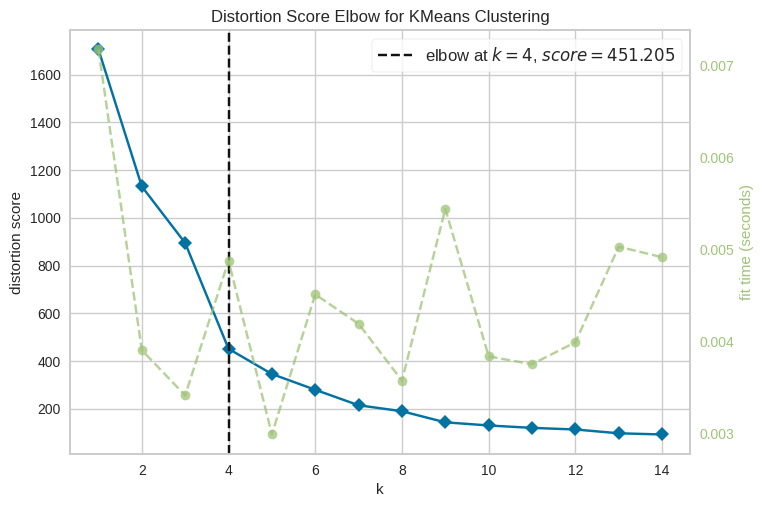

In [ ]:
# Initialize the KMeans model
model = KMeans(random_state = 1)

# Create the KElbowVisualizer to find the optimal number of clusters (k)
visualizer = KElbowVisualizer(model, k = (1, 15), timings = True)

# Fit the visualizer
visualizer.fit(k_means_df)

# Display the elbow plot
visualizer.show()
plt.show()

* The elbow clearly appears at k = 4, suggesting it as the optimal number of clusters, confirming the earlier observation.

* The optimal k = 4 according to KElbowVisualizer on distortion score.

For 2 number of clusters, the silhouette score is 0.42573007876197067.
For 3 number of clusters, the silhouette score is 0.4055190181792051.
For 4 number of clusters, the silhouette score is 0.6000548560115345.
For 5 number of clusters, the silhouette score is 0.6127095541991416.
For 6 number of clusters, the silhouette score is 0.6367970034002106.
For 7 number of clusters, the silhouette score is 0.6636419395255162.
For 8 number of clusters, the silhouette score is 0.6667109439961526.
For 9 number of clusters, the silhouette score is 0.7039302243349471.
For 10 number of clusters, the silhouette score is 0.7113181013698998.
For 11 number of clusters, the silhouette score is 0.7231738714556162.
For 12 number of clusters, the silhouette score is 0.7206577428040717.
For 13 number of clusters, the silhouette score is 0.7254316681324311.
For 14 number of clusters, the silhouette score is 0.7207450172788259.
For 15 number of clusters, the silhouette score is 0.729625521043359.


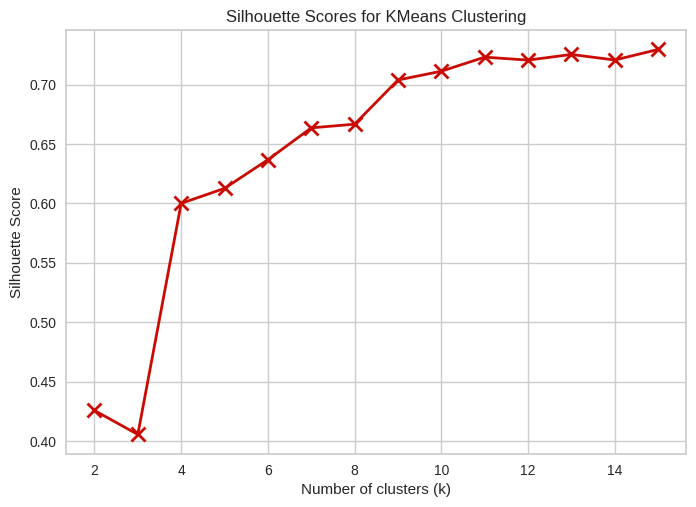

In [ ]:
# Initialize list to store silhouette scores
sil_score = []

# Define the range of cluster numbers to evaluate
cluster_list = range(2, 16)

# Loop through each cluster count
for n in cluster_list:
    # Fit KMeans clustering with n clusters
    cluster = KMeans(n_clusters = n, random_state = 1)
    preds = cluster.fit_predict(subset_df)

    # Calculate silhouette score for current clustering
    score = silhouette_score(k_means_df, preds)
    sil_score.append(score)

    # Print the score
    print(f'For {n} number of clusters, the silhouette score is {score}.')

# Plot silhouette scores for each k
plt.plot(cluster_list, sil_score, 'rx-', markersize = 10, markeredgewidth = 2, linewidth = 2)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for KMeans Clustering')
plt.show()

* k = 4 is where the graph shows significant increase in silhouette scores and increase rate drops after 4.

* k = 4+ seems to be the most balanced choice as it provides acceptable clustering quality, aligning with earlier elbow method findings.

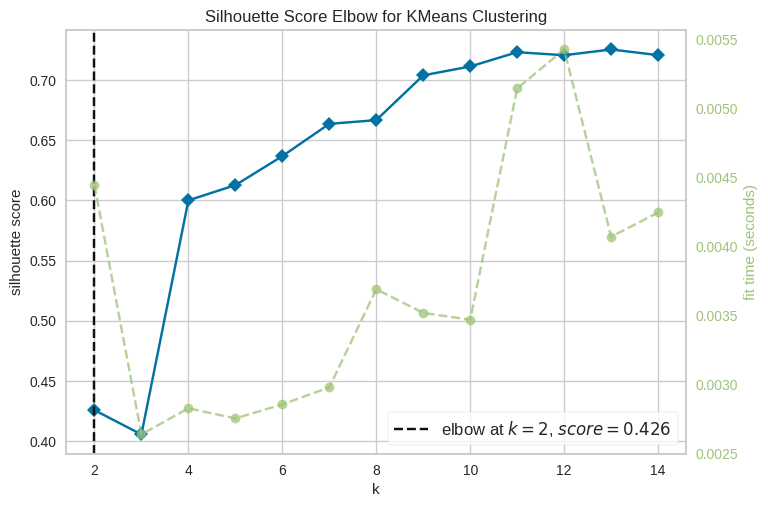

In [ ]:
# Create KMeans model
model = KMeans(random_state = 1)

# Use KElbowVisualizer to find the best number of clusters
visualizer = KElbowVisualizer(model, k = (2, 15), metric = 'silhouette', timings = True)

# Fit the model
visualizer.fit(k_means_df)

# Show the silhouette plot
visualizer.show()
plt.show()

* Although the tool automatically labeled k = 2 as the elbow, that is not the best choice based on the shape of the curve.

* The sharp improvement after k = 3, and stable high scores starting from k = 9 or 10, indicate the true optimal k is around 4–10.

* By visualizing the clusters, we may decide which number of k is optimal for the best number of clusters for this analysis.

In [ ]:
# Function to plot cluster on silhouette score
def silhouette_visualizer(n):
    '''
    Visualizes the silhouette plot for KMeans clustering with n clusters.

    Parameters:
    - n: Number of clusters to use for KMeans.

    Output:
    - Displays the silhouette plot for the specified number of clusters.
    '''
    # Create a silhouette visualizer for k-means clustering with n clusters
    visualizer = SilhouetteVisualizer(KMeans(n, random_state = 1))

    # Fit the visualizer to your scaled data
    visualizer.fit(k_means_df)

    # Display the silhouette plot
    visualizer.show()
    plt.show()

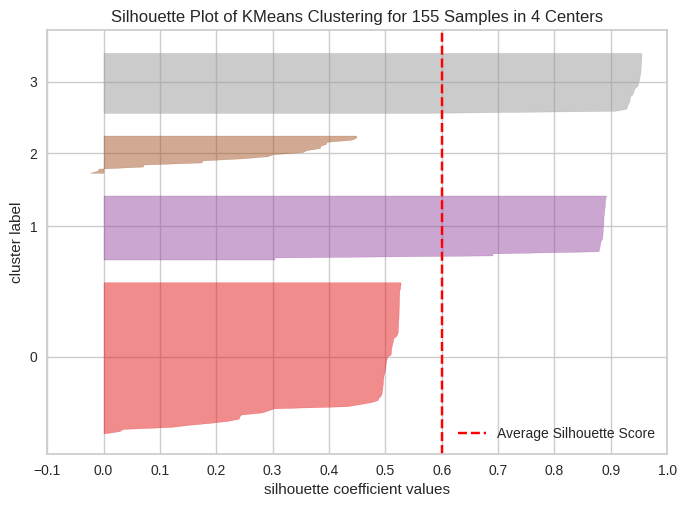

In [ ]:
# KMeans Clustering with 4 clusters
silhouette_visualizer(4)

* Some points in Cluster 2 have negative scores, indicating possible misclassification.

* Overall, 4 clusters show decent separation.

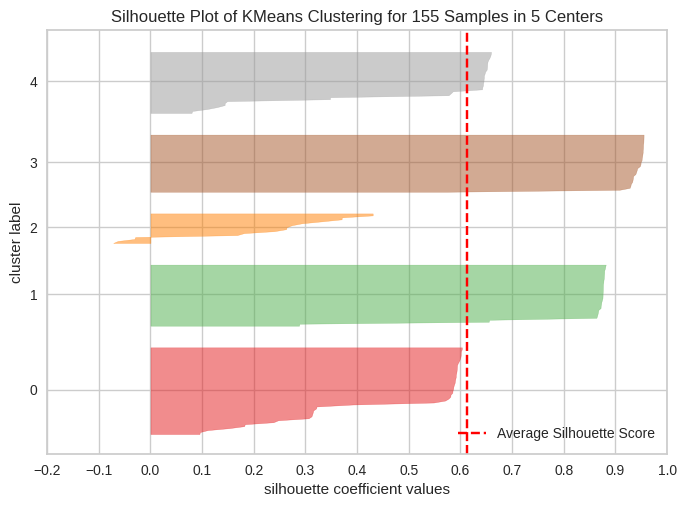

In [ ]:
# KMeans Clustering with 5 clusters
silhouette_visualizer(5)

* Cluster 2 again shows low silhouette scores with negative values, suggesting poor cohesion or possible misclassification.

* Cluster 3 and 4 show good separation with high silhouette values.

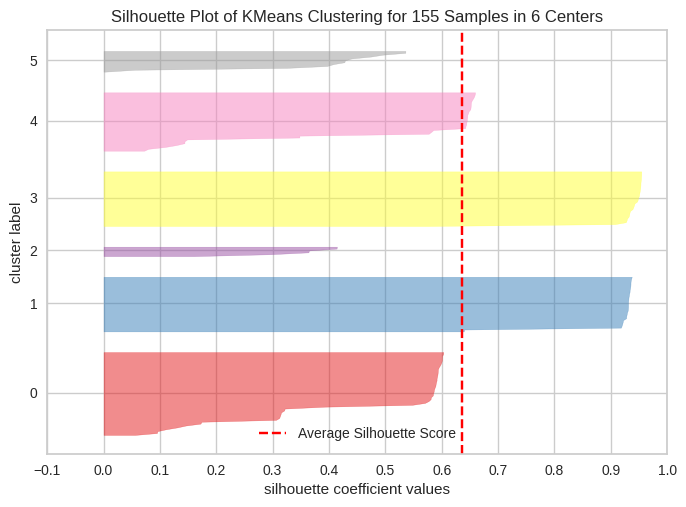

In [ ]:
# KMeans Clustering with 6 clusters
silhouette_visualizer(6)

* Cluster 2 has short bars, with some silhouette scores close to 0, suggesting that the points in this cluster are not well grouped and potential overlap

* Cluster 1 and 3 have taller and consistent bars, indicating better separation and cohesion.

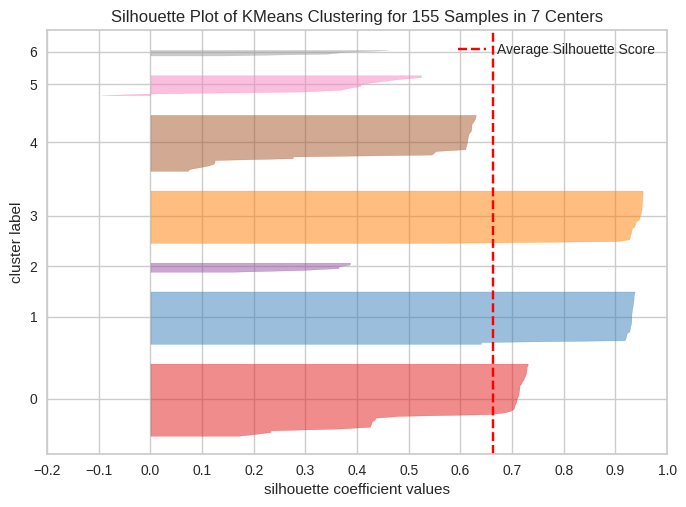

In [ ]:
# KMeans Clustering with 7 clusters
silhouette_visualizer(7)

* Cluster 2 again shows a few points with lower silhouette values.

* Cluster 0, 1, ,and 4 are well-formed with consistently high silhouette values.

* The average silhouette score remains similar to that of 6 clusters, indicating no significant gain in overall cohesion or separation.

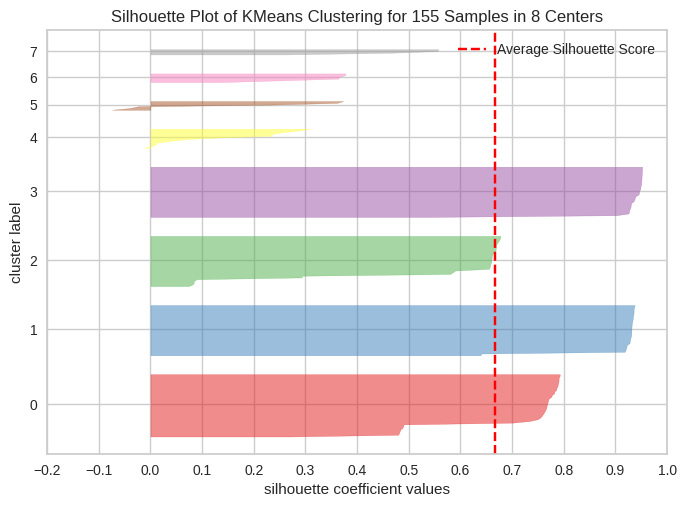

In [ ]:
# KMeans Clustering with 8 clusters
silhouette_visualizer(8)

* Clusters 4, 5, and 6 are very small with low silhouette scores.

* Clusters 0, 1, 2, and 3 remain stable with high silhouette scores.

* The overall average silhouette score hasn’t improved meaningfully from k = 6 or 7.

### Final Choice for K

* Judging by the cluster plots, k = 4 is a solid choice well-supported by the elbow and produces balanced clusters overall.

In [ ]:
# Initialize KMeans with 4 clusters
kmeans = KMeans(n_clusters = 4, random_state = 1)

# Fit the model
kmeans.fit(subset_df)

KMeans(n_clusters=4, random_state=1)

In [ ]:
# Select only the numeric columns from the original DataFrame
df1 = df.select_dtypes(np.number)

# Add the KMeans cluster labels
k_means_df['KM_segments'] = kmeans.labels_

# Add the same cluster labels to the original DataFrame
df1['KM_segments'] = kmeans.labels_

* Now we will create a cluster profile that shows the average value of each features in each cluster.

In [ ]:
# Compute the mean values of each feature for every cluster
cluster_profile = df1.groupby('KM_segments').mean()

# Add a column indicating the number of patients in each cluster
cluster_profile['Count of the patients'] = (
    df1.groupby('KM_segments')['Person ID'].count().values
)

# Drop unnecessary column from the profile
cluster_profile.drop('Person ID', axis = 1, inplace = True)
cluster_profile.drop('Sleep Disorder', axis = 1, inplace = True)

# Highlight the maximum value in each row
cluster_profile.style.highlight_max(color = 'navy', axis = 0)

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Count of the patients
KM_segments,,,,,,,,,,
0,43.702703,6.632432,6.702703,47.635135,5.756757,69.243243,6202.702703,130.878378,86.148649,74
1,57.437500,8.096875,9.000000,75.625000,3.062500,69.375000,6668.750000,139.937500,94.750000,32
2,34.894737,6.531579,5.315789,41.789474,6.842105,80.684211,4015.789474,134.210526,87.526316,19
3,49.766667,6.063333,6.000000,90.000000,8.000000,75.000000,10000.000000,140.000000,95.000000,30


**Cluster 0**:

Consists of middle-aged individuals (age 43.7) with moderate sleep duration (6.6 hours) and sleep quality (6.7), average physical activity levels (47.6), moderate stress (5.8), and blood pressure of (130.9/86.1). with 74 patients.

**Cluster 1**:

Represents the oldest group (age 57.4) with the longest sleep duration (8.1 hours) and highest sleep quality (9.0), high physical activity (75.6), low stress (3.1). However, they show high blood pressure (139.9/94.8), with 32 patients.

**Cluster 2**:

Includes the youngest individuals (age 34.9) with decent sleep duration (6.5 hours), low sleep quality (5.3), low physical activity (41.8), and high stress levels (6.8). They have moderately high blood pressure (134.2/87.5) with 19 patients.

**Cluster 3**:

Consists of adults (age 49.8) with the shortest sleep (6.1 hours), moderate sleep quality (6.0), the highest physical activity level (90.0), and the highest stress (8.0). Their blood pressure is the highest (140.0/95.0) with 30 patients.

In [ ]:
# Add the cluster labels to the original dataframe
df['KM_segments'] = kmeans.labels_

# Loop through each unique cluster
for cl in df["KM_segments"].unique():
    # Print the cluster number
    print("In cluster {}, these patients have sleeping disorder:".format(cl))

    # For the current cluster, group by Occupation and Sleep Disorder to count occurrences
    print(df[df["KM_segments"] == cl].groupby(["Occupation", "Sleep Disorder"]).size())
    print('*' * 50)

In cluster 2, these patients have sleeping disorder:
Occupation            Sleep Disorder
Doctor                1                 2
Engineer              1                 1
Lawyer                0                 2
Nurse                 0                 2
                      1                 2
Sales Representative  0                 2
Scientist             0                 2
Software Engineer     1                 1
Teacher               0                 3
                      1                 2
dtype: int64
**************************************************
In cluster 0, these patients have sleeping disorder:
Occupation   Sleep Disorder
Accountant   1                  7
Doctor       0                  2
             1                  1
Engineer     0                  1
             1                  4
Lawyer       0                  1
             1                  2
Salesperson  0                  1
             1                 29
Teacher      0                  1
     

**Cluster 0**:

Mostly teachers and salespeople with high rates of insomnia (25 and 29 respectively). Other occupations like engineers, lawyers, and accountants also show insomnia cases, indicating prevalence of insomnia.

**Cluster 1**:

Primarily nurses (30), all with sleep apnea and no cases of insomnia including 2 doctors, indicating a cluster free of insomnia.

**Cluster 2**:

A mix of various occupations, with both sleep apnea and insomnia. No single occupation or disorder dominates this cluster.

**Cluster 3**:

Almost entirely nurses, with 29 having sleep apnea and only 1 case of insomnia showing dominance of sleep apnea.

## Hierarchical Clustering

* KMeans clustering with k = 4 shows decent silhouette score of approximately 0.6, indicating reasonable clustering.

* However, we could try hierarchial clustering for better clustering quality.

In [ ]:
# Drop Person ID from the dataset as it is simply an identifier
subset_df.drop('Person ID', axis = 1, inplace = True)

In [ ]:
# Copy the subset dataset to use for Hierarchical Clustering
hc_df = subset_df

In [ ]:
# List of distance metrics to evaluate
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# List of linkage methods to evaluate
linkage_methods = ["single", "complete", "average", "weighted"]

# Initialize variable to store the highest cophenetic correlation
high_cophenet_corr = 0

# Initialize list to store the best distance metric and linkage method
high_dm_lm = [0, 0]

# Loop through each combination of distance metric and linkage method
for dm in distance_metrics:
    for lm in linkage_methods:
        # Compute the linkage matrix using current distance metric and linkage method
        Z = linkage(hc_df, metric = dm, method = lm)

        # Calculate the cophenetic correlation coefficient for the clustering
        c, coph_dists = cophenet(Z, pdist(hc_df))

        # Print the cophenetic correlation for current combination
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )

        # If current correlation is higher than previous best, update the best values
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

# Print a separator for clarity
print('*' * 100)

# Print the combination with the highest cophenetic correlation coefficient
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Cophenetic correlation for Euclidean distance and single linkage is 0.8215794056007002.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8124526828944715.
Cophenetic correlation for Euclidean distance and average linkage is 0.9139717165998561.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8509402549471838.
Cophenetic correlation for Chebyshev distance and single linkage is 0.8825684055861786.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.7794092858330808.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8563375142750489.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8206827596714796.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.6288760972615268.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.529501954937817.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.6097237615442939.
Cophenetic cor

* The best combination for cophenetic correlation of nearly 91 percent is Euclidean distance and average linkage.

* We will re-check from Euclidean distance and see which linkage provides the best cophenetic correlation to be sure.

In [ ]:
# List of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# Initialize variable to store the highest cophenetic correlation
high_cophenet_corr = 0

# Initialize list to store the best distance metric and linkage method
high_dm_lm = [0, 0]

# Loop through each combination of euclidean distance and linkage method
for lm in linkage_methods:
    Z = linkage(hc_df, metric = "euclidean", method = lm)
    c, coph_dists = cophenet(Z, pdist(hc_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

# Printing the combination of distance metric and linkage method with the highest cophenetic correlation
print('*'*100)
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Cophenetic correlation for single linkage is 0.8215794056007002.
Cophenetic correlation for complete linkage is 0.8124526828944715.
Cophenetic correlation for average linkage is 0.9139717165998561.
Cophenetic correlation for centroid linkage is 0.9146175637551414.
Cophenetic correlation for ward linkage is 0.8379736818633379.
Cophenetic correlation for weighted linkage is 0.8509402549471838.
****************************************************************************************************
Highest cophenetic correlation is 0.9146175637551414, which is obtained with centroid linkage.


* The centroid linkage method appears to be the best method among Euclidean distance in this case.

* Let's visualize the linkage methods in Euclidean distance with dendogram.

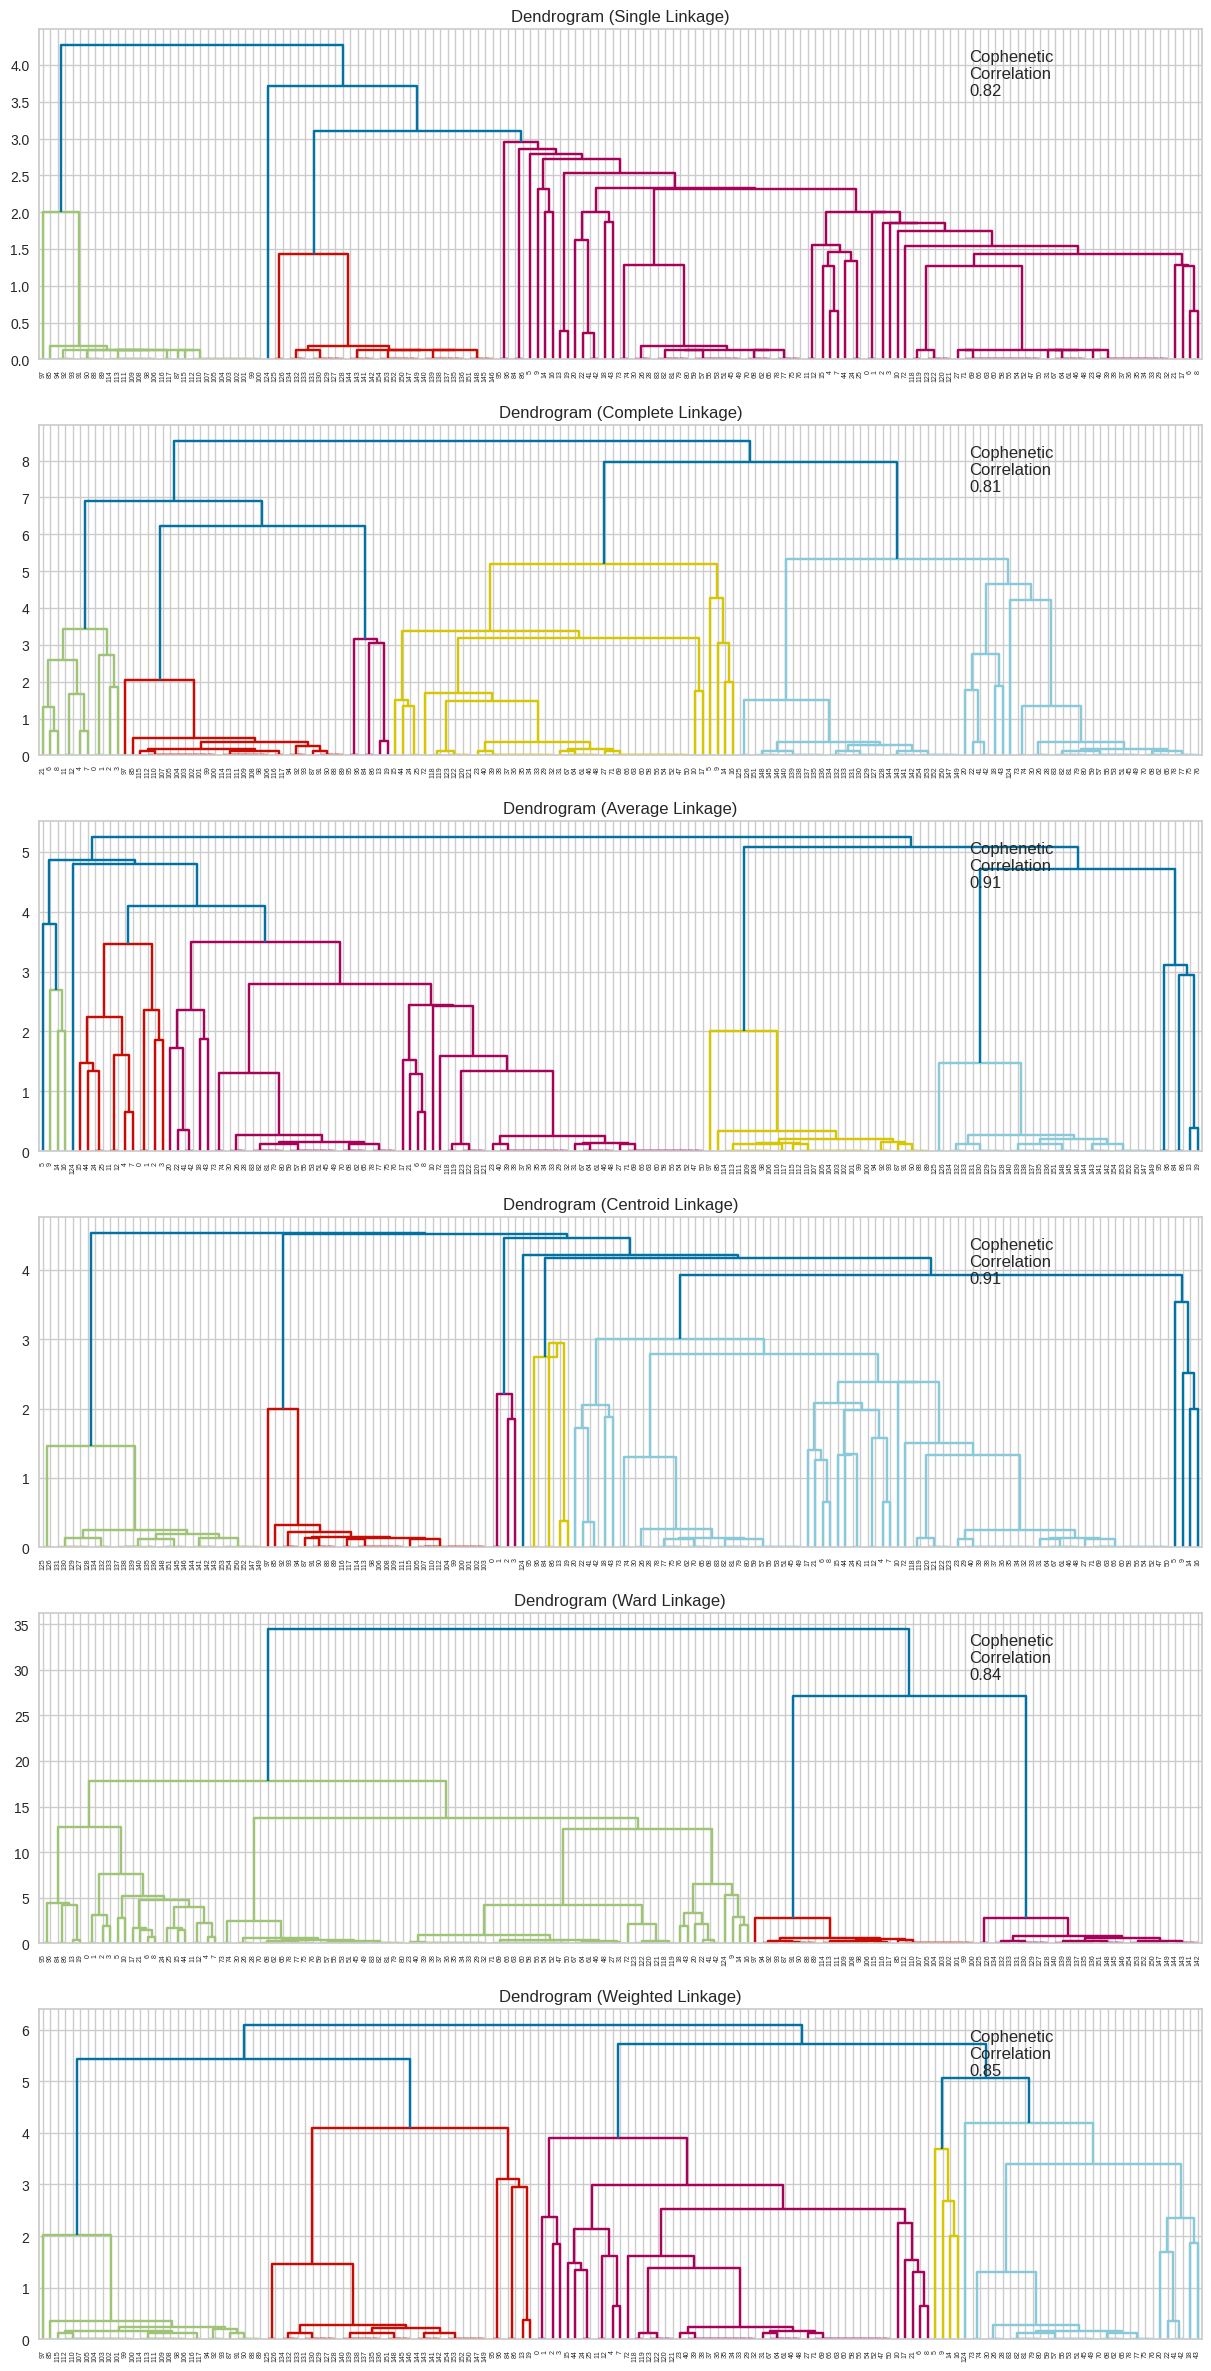

In [ ]:
# List of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# Lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# Create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(hc_df, metric = "euclidean", method = method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(hc_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

* The average and centroid linkage method provides the best cophenetic correlation score of approximately 0.91.

* The dendrogram reflects approximately 91% of the actual similarity structure in the data.

In [ ]:
# Create and print a dataframe to compare cophenetic correlations for different linkage methods
df_cc = pd.DataFrame(compare, columns = compare_cols)
df_cc = df_cc.sort_values(by = "Cophenetic Coefficient")
df_cc

,Linkage,Cophenetic Coefficient
1,complete,0.812
0,single,0.822
4,ward,0.838
5,weighted,0.851
2,average,0.914
3,centroid,0.915


* We select Euclidean distance and average linkage for hierarchical clustering, since AgglomerativeClustering does not support the centroid method.

* We set k as 4 as it shows clearly at at height ~3.5 intersects 4 large branches before they merg and this aligns with the findings in KMeans, appropriate for the small size of data we have.

In [ ]:
# Create an Agglomerative Hierarchical Clustering model
HCmodel = AgglomerativeClustering(n_clusters = 4, metric = "euclidean", linkage = "average")

# Fit the model
HCmodel.fit(hc_df)

AgglomerativeClustering(linkage='average', n_clusters=4)

In [ ]:
# Select only the numeric columns from the original DataFrame
df1 = df.select_dtypes(np.number)

# Add the KMeans cluster labels
k_means_df['KM_segments'] = kmeans.labels_

# Add the same cluster labels to the original DataFrame
df1['KM_segments'] = kmeans.labels_

In [ ]:
# Creating a copy of the original data
df2 = df.select_dtypes(np.number)

# Adding hierarchical cluster labels to the original and scaled dataframes
hc_df["HC_segments"] = HCmodel.labels_
df2["HC_segments"] = HCmodel.labels_

In [ ]:
# Calculate the mean profile for each hierarchical cluster
hc_cluster_profile = df2.groupby("HC_segments").mean()

# Add a new column showing the number of patients in each cluster
hc_cluster_profile['Count of the patients'] = (
    df2.groupby('HC_segments')['Person ID'].count().values
)

# Drop 'Person ID' column from the profile since it's no longer needed
hc_cluster_profile.drop('Person ID', axis = 1, inplace = True)
hc_cluster_profile.drop('KM_segments', axis = 1, inplace = True)
hc_cluster_profile.drop('Sleep Disorder', axis = 1, inplace = True)

# Highlight the highest value in each row
hc_cluster_profile.style.highlight_max(color = 'navy', axis = 0)

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Count of the patients
HC_segments,,,,,,,,,,
0,42.305882,6.557647,6.352941,45.223529,6.047059,71.141176,5784.705882,131.894118,86.682353,85
1,55.750000,8.013889,8.777778,74.166667,3.277778,70.944444,6305.555556,139.777778,94.222222,36
2,49.766667,6.063333,6.000000,90.000000,8.000000,75.000000,10000.000000,140.000000,95.000000,30
3,33.000000,7.025000,7.250000,56.250000,5.500000,69.000000,7500.000000,117.500000,77.500000,4


**Cluster 0**:
Composed of individuals (age 42.3) with average sleep duration (6.6 hours) and sleep quality (6.4). They engage in moderate physical activity (45.2), rmoderate stress (6.0), and average heart rate (71.1) and daily steps (5784.7). They have blood pressure of 131.9/86.7, with 85 patients.

**Cluster 1**:
Represents the oldest group (age 55.8) with the longest sleep (8.0 hours) and highest sleep quality (8.8). They are physically active (74.2), lowest in stress (3.3), and maintain the high blood pressure (139.8/94.2), with 36 patients.

**Cluster 2**:
Includes individuals (age 49.8) with the shortest sleep duration (6.1 hours), moderate sleep quality (6.0), most intense physical activity (90.0), highest stress (8.0) and highest heart rate (75.0). They walk the most (10,000 steps) and have the highest blood pressure (140.0/95.0), with 30 patients.

**Cluster 3**:
Youngest group (age 33.0) with fairly good sleep (7.0 hours), good sleep quality (7.3), moderate activity (56.3), and average stress (5.5), and the lowest (117.5/77.5), with only 4 patients.

In [ ]:
for cl in df2["HC_segments"].unique():
    print("In cluster {}, these patients have sleeping disorder:".format(cl))
    print(df[df["KM_segments"] == cl].groupby(["Occupation", "Sleep Disorder"]).size())
    print('*' * 50)

In cluster 0, these patients have sleeping disorder:
Occupation   Sleep Disorder
Accountant   1                  7
Doctor       0                  2
             1                  1
Engineer     0                  1
             1                  4
Lawyer       0                  1
             1                  2
Salesperson  0                  1
             1                 29
Teacher      0                  1
             1                 25
dtype: int64
**************************************************
In cluster 3, these patients have sleeping disorder:
Occupation  Sleep Disorder
Nurse       0                 29
            1                  1
dtype: int64
**************************************************
In cluster 1, these patients have sleeping disorder:
Occupation  Sleep Disorder
Doctor      0                  2
Nurse       0                 30
dtype: int64
**************************************************
In cluster 2, these patients have sleeping disorder:
Occupati

**Cluster 0**:
Primarily consists of teachers and salespeople with a high number of insomnia cases (25 and 29 respective). Also includes diverse occupations with high insomnia cases (engineers, accountants, doctors, and lawyers), indicating this cluster is strongly dominated by insomnia.

**Cluster 1**:
Mostly nurses (30) including 2 doctors, all with sleep apnea. There are no insomnia cases in this cluster.

**Cluster 2**:
A mixed group variety of occupations with balanced distribution of both sleep apnea and insomnia

**Cluster 3**:
Predominantly nurses (29), with almost all experiencing sleep apnea. There is only one case of insomnia in this cluster.

### KMeans vs Hierarchical

* With comparison of silhoutte score of approximately 0.6 and cophenetic correlation of 0.91, we select the hierarchical clustering as our final method to visualize with PCA and t-SNE.

## PCA & t-SNE Visualization

### PCA

In [ ]:
# Importing PCA
from sklearn.decomposition import PCA

# Initializing a PCA model
pca_test = PCA(n_components = 10)

# Fitting the PCA model to the data
pca_data_test = pca_test.fit_transform(subset_df)

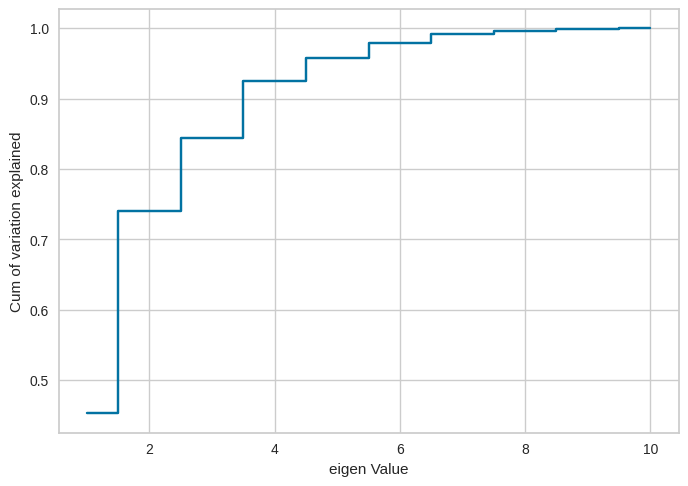

In [ ]:
# Plotting the cumulative sum of the variance explained by each components
plt.step(list(range(1,11)), np.cumsum(pca_test.explained_variance_ratio_), where = 'mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')

# Display the plot
plt.show()

* The first 3 principal components explain approximately 90% of the variance.

* After the 4th component, the gains in explained variance reduces significantly.

* We select three number of compents to keep most of the valuable information while simplifying the data.

In [ ]:
# Define PCA
pca = PCA(n_components = 3)

# Fit PCA to the subset_df
pca_data = pca.fit_transform(subset_df)

# Create a DataFrame with the PCA-transformed data
pca_df = pd.DataFrame(
    data = pca_data,
    columns=["Principal Component 1", "Principal Component 2", "Principal Component 3"]
)

# Display the first 5 rows of the PCA DataFrame
pca_df.head()

,Principal Component 1,Principal Component 2,Principal Component 3
0,-2.963,2.239,3.503
1,-2.963,2.239,3.503
2,-3.599,1.828,2.951
3,-2.538,0.757,2.519
4,-2.718,1.009,2.217


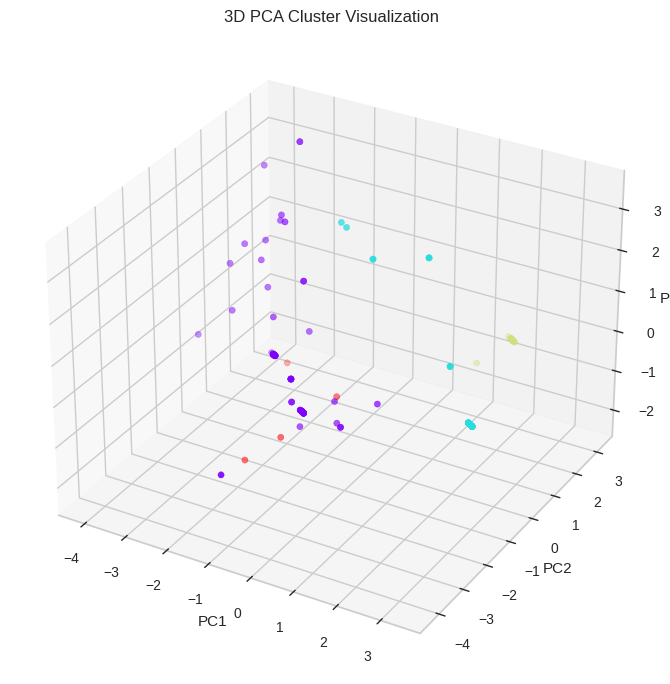

In [ ]:
# Create a 3D figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection = '3d')

# Create a 3D scatter plot
ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c = hc_df.HC_segments, cmap = 'rainbow')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D PCA Cluster Visualization')
plt.tight_layout()

# Display the plot
plt.show()

* Visually, the clusters are separated but not very well.

* Some clusters overlap more, indicating those groups may share similar characteristics with less distinct boundaries.

### t-SNE

In [ ]:
# Performing t-SNE
from sklearn.manifold import TSNE

# Deinfe t-SNE
tsne = TSNE(n_components = 2, random_state = 1)

# Transform the data
tsne_data = tsne.fit_transform(subset_df)

In [ ]:
# Create a DataFrame using the transformed data
tsne_df = pd.DataFrame(data = tsne_data, columns = ["Component 1", "Component 2"])

# Display the final 5 values of the DataFrame
tsne_df.tail()

,Component 1,Component 2
150,203.304,47.505
151,140.682,53.486
152,203.304,47.505
153,203.304,47.505
154,186.045,25.245


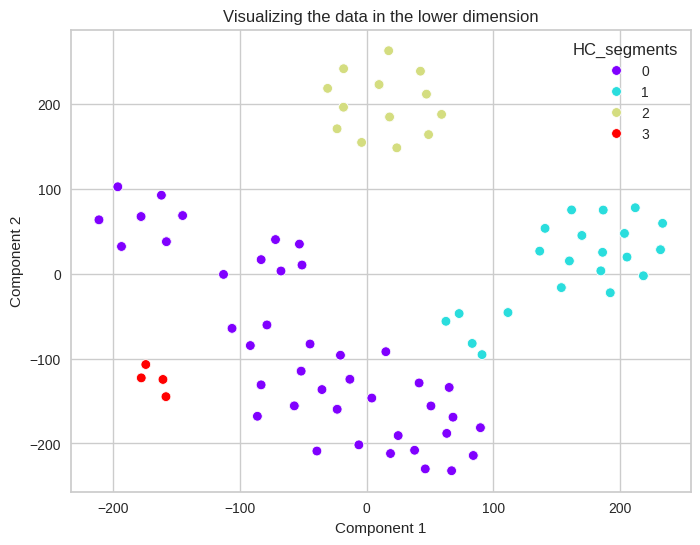

In [ ]:
# Set the figure size for the plot
plt.figure(figsize = (8, 6))

# Create a scatter plot using the t-SNE components
sns.scatterplot(
    data = tsne_df,
    x = "Component 1",
    y = "Component 2",
    hue = hc_df.HC_segments,
    palette = 'rainbow'
)
plt.title("Visualizing the data in the lower dimension")

# Display the plot
plt.show()

* The clusters are well-separated, especially clusters 1 and 2, indicating distinct patterns.

* Cluster 0 appears more spread out and Cluster 3 is small but compact.

* This seems much better cluster visualization compared to PCA.

* We could make the visualization better by deploying different perplexities.

Visualizing the lower dimensional representation of data for different values of perplexity



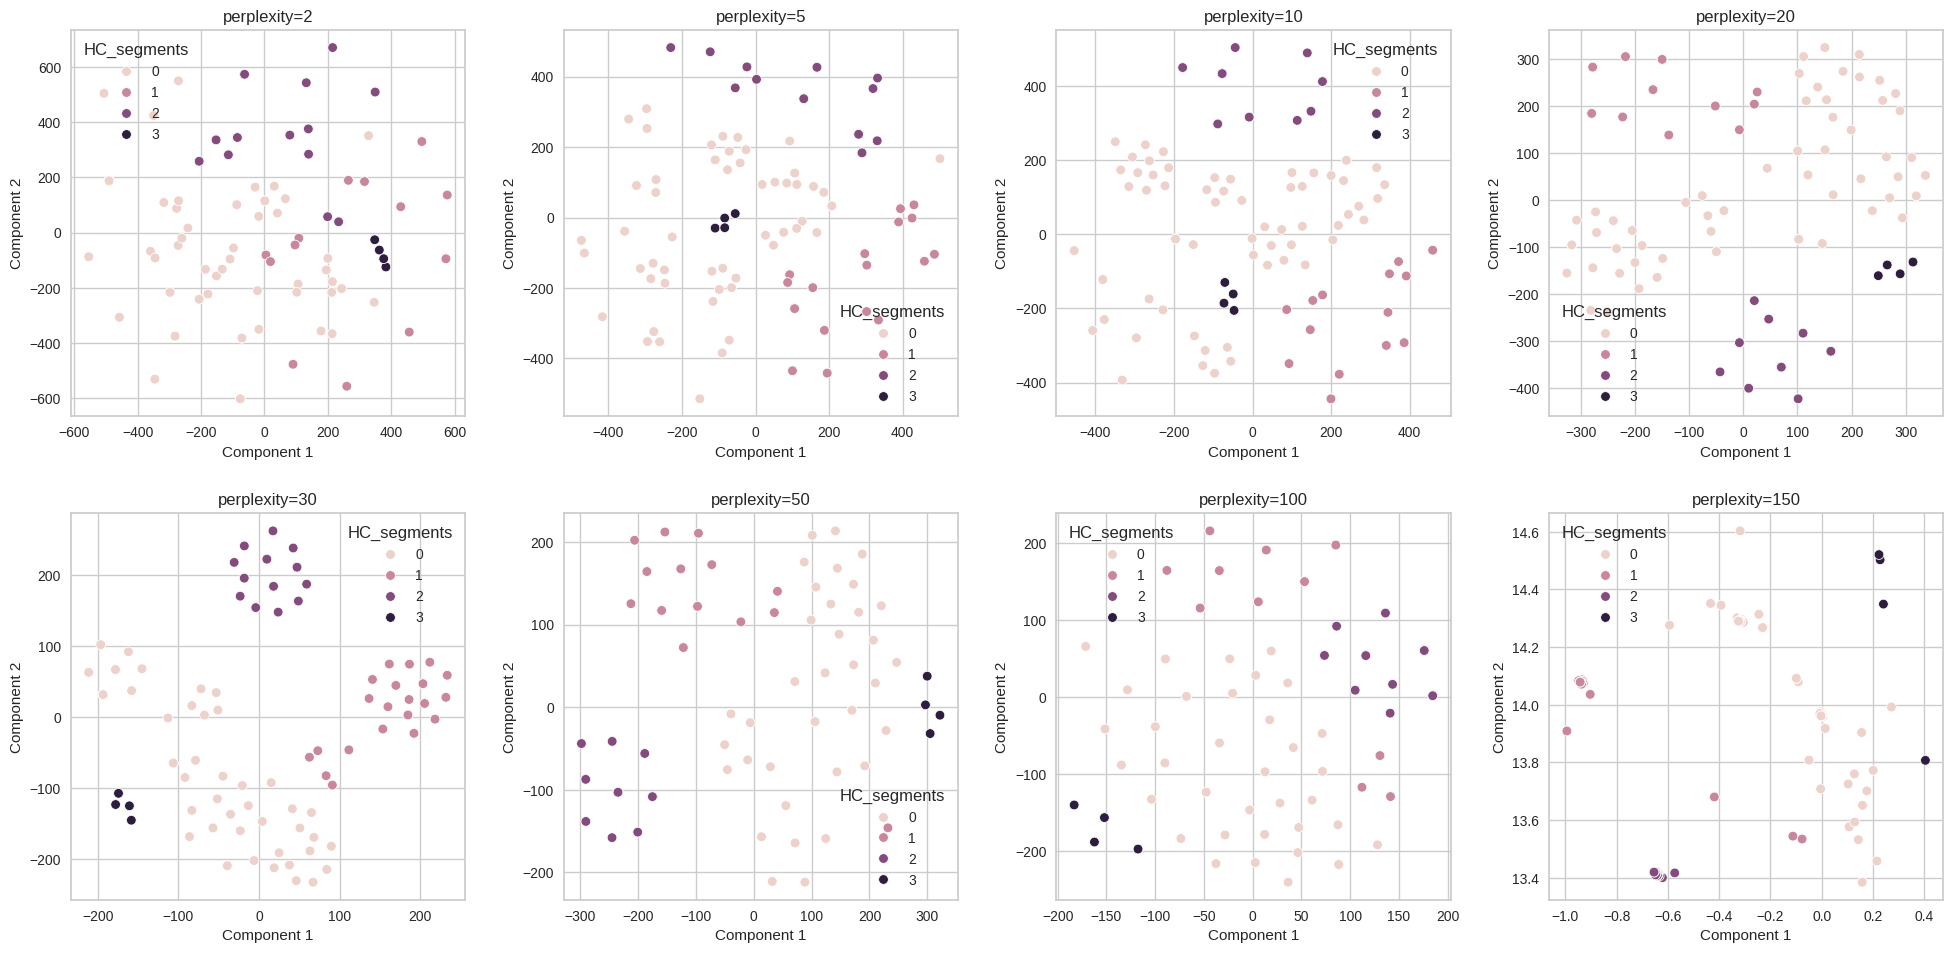

In [ ]:
# Perplexities to use for visualization
perplexity = [2, 5, 10, 20, 30, 50, 100, 150]

# Plot 8 plots with different perplexities
plt.figure(figsize = (20, 10))
print(
    "Visualizing the lower dimensional representation of data for different values of perplexity\n"
)

# Iterate through the perplexities and plot all 8 visualizations
for i in range(len(perplexity)):

    tsne = TSNE(n_components = 2, perplexity = perplexity[i], n_jobs = -2, random_state = 1)
    X = tsne.fit_transform(subset_df)

    X_df = pd.DataFrame(data = X, columns=["Component 1", "Component 2"])

    plt.subplot(2, int(len(perplexity) / 2), i + 1)

    plt.title("perplexity=" + str(perplexity[i]))
    sns.scatterplot(data = X_df, x = "Component 1", y = "Component 2", hue = hc_df.HC_segments),
    plt.tight_layout(pad = 2)

* Among 8 plots, perplexity = 30 offers the clearest cluster separation and is the best choice for visualization, which is the default perplexity value.

## Conclusion

* Hierarchical clustering, supported by a strong cophenetic correlation (0.91) and clearer visual distinction in t-SNE, was selected as the final model.

* While the cophenetic correlation of 91 percent seems unrealistic, the t-SNE visualization of hierarchial clustering shows that clusters are cleanly seperated.

* The analysis revealed distinct health behavior patterns among patients with sleep disorders (sleep apnea and insomnia), which can help in tailoring interventions based on cluster profiles.

* This project analysis may aid in developing personalized treatment plans by grouping patients with similar behavioral and physiological profiles, enabling healthcare providers to better target interventions for sleeping disorders.